# Análisis y Exploración de Datos - Tienda Online

Este notebook presenta un análisis exploratorio de ventas de una tienda online utilizando el dataset **Online Retail II**.  
El objetivo es comprender el comportamiento de los clientes y los patrones de compra, identificar productos destacados y detectar oportunidades para optimizar las decisiones del negocio.

A lo largo del análisis se aplicarán técnicas de preprocesamiento de datos, detección de valores nulos o inconsistentes, generación de variables relevantes como *TotalPrice* o *YearMonth*, y agrupaciones por cliente y país para obtener insights estratégicos.


# CARGA DEL DATASET Y LIBRERIAS


## Importacion de librerias

In [481]:
#
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from itertools import combinations
from collections import Counter
import numpy as np
import matplotlib.dates as mdates


## Carga del dataset

In [482]:
"""
from google.colab import files

#  Sube el dataset
uploaded = files.upload()
"""

'\nfrom google.colab import files\n\n#  Sube el dataset\nuploaded = files.upload()\n'

In [483]:
# Definimos la ruta del archivo Excel
file_path = "online_retail_II.xlsx"

# Cargamos el archivo como objeto Excel para acceder a sus hojas
xls = pd.ExcelFile(file_path)

# Leemos las dos hojas del archivo que contienen los registros de ventas por año
df1 = xls.parse('Year 2009-2010')
df2 = xls.parse('Year 2010-2011')

# Agregar columna identificadora del origen
df1['Year'] = '2009-2010'
df2['Year'] = '2010-2011'

# Unir en un único DataFrame
df = pd.concat([df1, df2], ignore_index=True)


# PREPROCESAMIENTO DE DATOS


## 1. Revisión estructural del conjunto de datos



A continuación se importan las librerías necesarias para el análisis y se establece el estilo de los gráficos.
Además, se realiza una primera inspección estructural del dataset para conocer su tamaño, columnas, tipos de datos y valores únicos por campo. Esto permite anticipar posibles ajustes de formato y comprender la naturaleza de los datos antes del preprocesamiento.

In [484]:
# 1. Mostrar tamaño del dataset
print(f"Tamaño del dataset: {df.shape[0]} filas y {df.shape[1]} columnas")

# 2. Mostrar columnas disponibles
print("\nColumnas disponibles:")
display(pd.DataFrame(df.columns, columns=["Columnas"]))

# 3. Tipos de datos por columna
print("\nTipos de datos por columna:")
display(pd.DataFrame(df.dtypes, columns=["Tipo de dato"]))

# 4. Cantidad de valores únicos por columna
print("\nCantidad de valores únicos por columna:")
display(df.nunique().sort_values(ascending=False).to_frame("Valores únicos"))

# 5. Visualizar primeras 10 columnas
print("\n👁 Vista previa de los primeros 10 registros:")
df.head(10)

Tamaño del dataset: 1067371 filas y 9 columnas

Columnas disponibles:


,Columnas
0,Invoice
1,StockCode
2,Description
3,Quantity
4,InvoiceDate
5,Price
6,Customer ID
7,Country
8,Year



Tipos de datos por columna:


,Tipo de dato
Invoice,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
Price,float64
Customer ID,float64
Country,object
Year,object



Cantidad de valores únicos por columna:


,Valores únicos
Invoice,53628
InvoiceDate,47635
Customer ID,5942
Description,5698
StockCode,5305
Price,2807
Quantity,1057
Country,43
Year,2



👁 Vista previa de los primeros 10 registros:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-2010
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-2010
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-2010
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-2010
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-2010
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom,2009-2010
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-2010
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom,2009-2010
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom,2009-2010
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom,2009-2010


## 2. Tratamiento de valores nulos e inconsistentes


### 2.1 Nulos
En esta etapa se realiza un análisis exploratorio para detectar la presencia de valores faltantes en las distintas columnas del conjunto de datos.

Se calcula la cantidad total de valores nulos y el porcentaje que representan respecto al total de registros.  
Este paso es clave para tomar decisiones fundamentadas sobre qué columnas requieren limpieza o tratamiento especial en el preprocesamiento posterior.

In [485]:
# Conteo de valores nulos por columna
null_counts = df.isnull().sum()

# Porcentaje de valores nulos respecto al total de registros
null_percent = (null_counts / len(df)) * 100

# Crear resumen organizado en un DataFrame
null_summary = pd.DataFrame({
    'Columna': null_counts.index,
    'Valores nulos': null_counts.values,
    'Porcentaje (%)': null_percent.values
}).sort_values(by='Valores nulos', ascending=False).reset_index(drop=True)

# Visualización con estilo claro y uniforme
print("Conteo de valores nulos por columna:")
display(null_summary.style.format({'Porcentaje (%)': '{:.2f}'}))

Conteo de valores nulos por columna:


,Columna,Valores nulos,Porcentaje (%)
0,Customer ID,243007,22.77
1,Description,4382,0.41
2,Invoice,0,0.00
3,Quantity,0,0.00
4,StockCode,0,0.00
5,InvoiceDate,0,0.00
6,Price,0,0.00
7,Country,0,0.00
8,Year,0,0.00


2.1.1 Análisis de la columna `Customer ID` y justificación de su tratamiento



In [486]:
# Contar registros con y sin 'Customer ID'

df_con_id = df[df['Customer ID'].notnull()]
df_sin_id = df[df['Customer ID'].isnull()]

con_id = len(df_con_id)
sin_id = len(df_sin_id)
total = len(df)

# Crear DataFrame resumen
resumen_id = pd.DataFrame({
    "Categoría": ["Con Customer ID", "Sin Customer ID", "Total"],
    "Cantidad": [con_id, sin_id, total],
    "Porcentaje": [
        f"{round(con_id/total*100, 2)}%",
        f"{round(sin_id/total*100, 2)}%",
        "100%"
    ]
})

# Mostrar tabla resumen
print(" Distribución de registros según disponibilidad de Customer ID:")
display(resumen_id.style)

 Distribución de registros según disponibilidad de Customer ID:


,Categoría,Cantidad,Porcentaje
0,Con Customer ID,824364,77.23%
1,Sin Customer ID,243007,22.77%
2,Total,1067371,100%


La columna `Customer ID` corresponde al identificador único de cada cliente que realizó una compra. Este dato resulta clave para llevar adelante análisis centrados en el comportamiento del consumidor, como la frecuencia de compra, el gasto promedio por usuario o la fidelización.

Al revisar la calidad de los datos, se observó que esta columna presenta un porcentaje significativo de valores nulos: 22,77% del total de registros. Es decir, en más de una quinta parte de las transacciones no se identificó al cliente.


**Análisis y decisión**

La ausencia de este dato puede deberse a errores de registro o a compras realizadas sin asociar un perfil de cliente. Si bien estos registros no son útiles para análisis por cliente, sí pueden aportar información relevante en estudios generales de ventas, como por producto, país o fecha.

Dado que los registros sin `Customer ID` aún contienen otros datos valiosos para el análisis exploratorio general, se decidió conservarlos. Sin embargo, para asegurar la calidad y claridad de los análisis, se trabajará con dos subconjuntos de datos: uno que incluye todas las transacciones y otro que conserva únicamente aquellas con cliente identificado. Esta separación, se realizara previo a la visualizacion de datos y permitirá realizar análisis específicos sin comprometer la integridad de los resultados.



2.1.2 Análisis de la columna `Description` y justificación de su tratamiento**:

La columna `Description` corresponde al nombre o descripción del producto involucrado en cada transacción. Se trata de un dato fundamental para realizar análisis vinculados a productos, como determinar cuáles son los más vendidos, agruparlos por categoría o identificar patrones de compra.

Al revisar los valores nulos del dataset, se detectaron algunos registros en los que este campo aparece vacío. En este apartado se detalla cuántos casos son, qué porcentaje representan sobre el total y se justifica el tratamiento que se les dará.

**Análisis y decisión**

No contar con la descripción del producto impide incluir esos registros en análisis relacionados con artículos o categorías, ya que no es posible saber qué se vendió.

Dado que la cantidad de registros sin descripción representa una proporción muy baja del total (menor al 0.5%), se decidió eliminarlos. Esta acción no afecta de manera significativa al volumen ni a la representatividad del conjunto de datos, y permite mantener la consistencia del análisis.

In [487]:
# Contar registros con valores nulos en 'Description'
desc_null_count = df['Description'].isnull().sum()
total_rows = len(df)
desc_null_pct = round((desc_null_count / total_rows) * 100, 2)

print(f"Registros con 'Description' nula: {desc_null_count} ({desc_null_pct}%)")

# Justificación:
# Representan un porcentaje muy bajo y no aportan valor para el análisis de productos,
# ya que no se puede saber qué fue lo que se vendió.

# Eliminar registros con 'Description' nula
df = df.dropna(subset=['Description'])

# Comentario final del tratamiento (puede variar según ejecución previa)
print(f"Se eliminaron {desc_null_count} registros con 'Description' nula ({desc_null_pct}%).")

Registros con 'Description' nula: 4382 (0.41%)
Se eliminaron 4382 registros con 'Description' nula (0.41%).


Se agrega una columna "IsReturn" para marcar las devoluciones

In [488]:
df['IsReturn'] = df['Invoice'].astype(str).str.startswith('C') | (df['Quantity'] < 0)


**Diagnóstico general de valores nulos**

Antes de continuar con el preprocesamiento, se genera una visualización general de los valores faltantes en todas las columnas para facilitar el diagnóstico global.

Con este bloque se han identificado y tratado los principales valores faltantes del dataset:

Se conservaron registros con `Customer ID` nulo por su valor informativo.
Se eliminaron los registros sin `Description` por no aportar valor al análisis.
Se visualizó el panorama general de valores nulos restantes.
Esto deja el conjunto de datos en condiciones más limpias y confiables para continuar con el análisis.

In [597]:
# Conteo y porcentaje de valores nulos por columna
null_counts = df.isnull().sum()
null_percent = (null_counts / len(df)) * 100

# Crear resumen ordenado
null_summary = pd.DataFrame({
    'Columna': null_counts.index,
    'Valores nulos': null_counts.values,
    'Porcentaje (%)': null_percent.values
}).sort_values(by='Valores nulos', ascending=False).reset_index(drop=True)

# Mostrar tabla con estilo
print("Resumen de valores nulos por columna:")
display(null_summary.style.format({'Porcentaje (%)': '{:.2f}'}))

Resumen de valores nulos por columna:


,Columna,Valores nulos,Porcentaje (%)
0,Invoice,0,0.00
1,StockCode,0,0.00
2,Description,0,0.00
3,Quantity,0,0.00
4,InvoiceDate,0,0.00
5,Price,0,0.00
6,Customer ID,0,0.00
7,Country,0,0.00
8,Year,0,0.00
9,IsReturn,0,0.00


### 2.2 Valores inconsistentes (Quantity y Price)



#### 2.2.1 Detección de valores inconsistentes

En esta sección se analizarán registros con valores **negativos** en las columnas `Quantity` y `Price`.

Estas variables representan la cantidad de productos vendidos y su precio por unidad.  
Por tanto, los valores negativos pueden ser indicadores de **inconsistencias** o tener un significado especial (por ejemplo, devoluciones).

Antes de tomar decisiones, se identificará cuántos registros presentan estos valores para evaluar su impacto y proceder a su análisis.

In [490]:
# Contar registros con valores negativos en Quantity y Price
neg_qty = df[df['Quantity'] < 0]
neg_price = df[df['Price'] < 0]

# Crear resumen en tabla
resumen_negativos = pd.DataFrame({
    "Columna": ["Quantity", "Price"],
    "Cantidad de valores negativos": [neg_qty.shape[0], neg_price.shape[0]]
})

# Mostrar resumen con estilo
print("Registros con valores negativos:")
display(resumen_negativos.style)

# Mostrar ejemplos
print("\n Ejemplos de registros con Quantity negativa:")
display(neg_qty.head().style)

print("\n Ejemplos de registros con Price negativa:")
display(neg_price.head().style)

Registros con valores negativos:


,Columna,Cantidad de valores negativos
0,Quantity,20261
1,Price,5



 Ejemplos de registros con Quantity negativa:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,IsReturn
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.950000,16321.000000,Australia,2009-2010,True
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.650000,16321.000000,Australia,2009-2010,True
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.250000,16321.000000,Australia,2009-2010,True
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.100000,16321.000000,Australia,2009-2010,True
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.950000,16321.000000,Australia,2009-2010,True



 Ejemplos de registros con Price negativa:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,IsReturn
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.360000,nan,United Kingdom,2009-2010,False
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.790000,nan,United Kingdom,2009-2010,False
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.870000,nan,United Kingdom,2009-2010,False
825444,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.060000,nan,United Kingdom,2010-2011,False
825445,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.060000,nan,United Kingdom,2010-2011,False


#### 2.2.2 Análisis conceptual de los valores negativos



> Análisis de `Quantity` negativa:

Se encontraron 20.261 registros con `Quantity` negativa.

Al revisar ejemplos, se observa que muchos corresponden a productos específicos (como canastas o decoraciones) con cantidades como -6, -4 o -12.

Esto sugiere que no se trata de errores, sino de devoluciones o cancelaciones de pedidos, lo cual es común en datos de ventas reales.

- Conclusión: No son errores, sino eventos válidos del negocio. Su presencia puede enriquecer el análisis si se desea evaluar comportamiento postventa, devoluciones por país o cliente, etc.


> Análisis de `Price` negativa:

Solo hay 5 registros con `Price` negativo.

La descripción es "Adjust bad debt", todos con cantidades de 1 unidad y precios extremadamente negativos (como -53594.36).

No tienen Customer ID, y el país es United Kingdom.

Representan ajustes contables o cancelaciones por deuda incobrable.

- Conclusión: Estos valores no aportan al análisis comercial o de comportamiento de compra. De hecho, pueden distorsionar los cálculos de ingresos o promedios de venta si se mantienen.

#### 2.2.3 Tratamiento de valores negativos en Quantity y Price


Con base en el análisis anterior, se decide:

> -  Conservar los registros con `Quantity` negativa:
    Representan devoluciones o cancelaciones reales que pueden ser útiles para estudios de postventa o comportamiento de clientes.

> -  Eliminar los registros con `Price` negativa:
    Corresponden a ajustes contables no asociados a clientes, sin valor para el análisis comercial, y que podrían distorsionar métricas como ingresos, precios promedio o ventas totales.

In [491]:
# Filtrar registros con Price negativa
neg_price = df[df['Price'] < 0]
price_neg_count = neg_price.shape[0]
total_rows_before = df.shape[0]

# Eliminar los registros
df = df[df['Price'] > 0]
total_rows_after = df.shape[0]
rows_removed = total_rows_before - total_rows_after

# Crear tabla resumen
eliminacion_resumen = pd.DataFrame({
    "Descripción": [
        "Registros con Price negativa eliminados",
        "Total de registros antes de eliminar",
        "Total de registros después de eliminar"
    ],
    "Cantidad": [rows_removed, total_rows_before, total_rows_after]
})

# Mostrar con estilo
print(" Resumen de limpieza: Eliminación de precios negativos")
display(eliminacion_resumen.style)

 Resumen de limpieza: Eliminación de precios negativos


,Descripción,Cantidad
0,Registros con Price negativa eliminados,1825
1,Total de registros antes de eliminar,1062989
2,Total de registros después de eliminar,1061164


## 3. Normalización de columnas



En esta etapa se realiza una normalización de algunas columnas clave del conjunto de datos para mejorar la integridad y facilitar los análisis posteriores.

Se corrigen inconsistencias en los tipos de datos, se eliminan decimales innecesarios en campos numéricos y se convierten identificadores a un formato más apropiado.
Estas transformaciones garantizan una estructura más limpia, comprensible y coherente, manteniendo siempre los valores nulos cuando es necesario.

### 3.1 Transformacion de columnas
Se corrigen inconsistencias en los tipos de datos, se eliminan decimales innecesarios en campos numéricos y se convierten identificadores a un formato más apropiado. Estas transformaciones garantizan una estructura más limpia, comprensible y coherente, manteniendo siempre los valores nulos cuando es necesario.

In [492]:
# Redondear precios a dos decimales para facilitar su lectura y análisis
df['Price'] = df['Price'].round(2)

# Convertir Customer ID a entero sin perder valores nulos
df['Customer ID'] = df['Customer ID'].astype('Int64')

### 3.2 Creacion de columnas

#### 3.2.1 Creacion de columnas: `InvoiceYear`, `InvoiceMonth`, `InvoiceWeekday`, `InvoiceHour`, `DateOnly`

In [493]:
print("\nTipos de datos por columna:")
display(pd.DataFrame(df.dtypes, columns=["Tipo de dato"]))


Tipos de datos por columna:


,Tipo de dato
Invoice,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
Price,float64
Customer ID,Int64
Country,object
Year,object
IsReturn,bool



Confirmamos que la columna `InvoiceDate` ya se encuentra en formato `datetime64`, lo cual permite la extracción directa de componentes temporales como año, mes o día.”

In [494]:
# A partir de la columna 'InvoiceDate' (en formato datetime), se crean nuevas variables temporales
# para facilitar análisis por año, mes, día de la semana y hora.

# Año
df['InvoiceYear'] = df['InvoiceDate'].dt.year

# Mes
df['InvoiceMonth'] = df['InvoiceDate'].dt.month

# Día de la semana
df['InvoiceWeekday'] = df['InvoiceDate'].dt.day_name()

# Hora
df['InvoiceHour'] = df['InvoiceDate'].dt.hour

# Fecha sin hora
df['DateOnly'] = df['InvoiceDate'].dt.date

# Visualizamos
print("Verificación de nuevas columnas temporales derivadas de 'InvoiceDate'")
display(
    df[['InvoiceDate', 'InvoiceYear', 'InvoiceMonth', 'InvoiceWeekday', 'InvoiceHour', 'DateOnly']]
    .head(10)
    .style)

Verificación de nuevas columnas temporales derivadas de 'InvoiceDate'


,InvoiceDate,InvoiceYear,InvoiceMonth,InvoiceWeekday,InvoiceHour,DateOnly
0,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
1,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
2,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
3,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
4,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
5,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
6,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
7,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
8,2009-12-01 07:46:00,2009,12,Tuesday,7,2009-12-01
9,2009-12-01 07:46:00,2009,12,Tuesday,7,2009-12-01


**Justificación final:**

La creación de estas variables permite realizar análisis temporales más específicos, como:

Comportamiento de compras por año o mes.

Identificación de patrones según el día de la semana o la hora del día.

Agrupaciones por fecha específica sin tener en cuenta la hora exacta.

> Se decide conservar la columna `InvoiceDate` porque contiene la información completa y original en formato datetime, lo cual puede resultar útil para análisis avanzados (por ejemplo, intervalos entre compras, ordenamiento cronológico o reconstrucción de eventos).
De esta forma, se mantienen tanto la granularidad original como las nuevas variables derivadas para facilitar múltiples enfoques de análisis.




#### 3.2.2 Creación de nueva columna: `TotalPrice`

En esta etapa se incorpora una nueva columna al conjunto de datos, con el objetivo de facilitar análisis futuros relacionados con el comportamiento de ventas.
La columna `TotalPrice` representa el valor monetario total de cada línea de factura, resultado de multiplicar la cantidad de artículos por su precio unitario. Esta variable será clave para estudiar ingresos por cliente, país o producto.

In [495]:
# Crear la columna 'TotalPrice' si aún no existe
df['TotalPrice'] = df['Quantity'] * df['Price']

# Visualizar muestra
df[['Quantity', 'Price', 'TotalPrice']].head()

,Quantity,Price,TotalPrice
0,12,6.95,83.4
1,12,6.75,81.0
2,12,6.75,81.0
3,48,2.10,100.8
4,24,1.25,30.0


Se incorporó la columna `TotalPrice` al dataset, calculando el valor total por cada transacción.
Esta transformación no altera los datos originales, pero sí amplía el potencial analítico del conjunto, permitiendo evaluaciones posteriores más completas, como los ingresos por cliente o país.
Su creación es una etapa fundamental en el preprocesamiento antes de pasar al análisis estadístico o la visualización de datos.

In [496]:
df['TotalPrice'] = df['Quantity'] * df['Price']

## 4. Agrupaciones para análisis exploratorio inicial



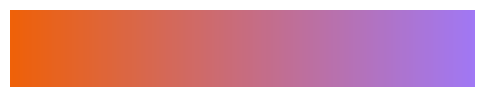

In [497]:
# Configuración de estilo gráfico
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 13


# Colores de gradientes de naranja a gris
colors = ["#ef6109",  # naranja
          "#a178f4"]  # violeta

# Crea el colormap
mi_gradiente = LinearSegmentedColormap.from_list("naranja_violeta", colors)

# Colores de gradientes de naranja a gris
colors = ["#dddddd",  # gris
          "#ef6109"]  # naranja

# Crea el colormap
naranja_gradiente = LinearSegmentedColormap.from_list("naranja_violeta", colors)

# Colores de gradientes de naranja a gris
colors = ["#dddddd",  # griis
          "#a178f4"]  # violeta

violeta_gradiente = LinearSegmentedColormap.from_list("naranja_violeta", colors)

# Ejemplo de cómo visualizarlo
fig, ax = plt.subplots(figsize=(6,1))
gradient = np.linspace(0,1,256).reshape(1,-1)
ax.imshow(gradient, aspect='auto', cmap=mi_gradiente)
ax.set_axis_off()
plt.show()

# Crear una lista de 10 colores
valores = np.linspace(0, 1, 10)
colores_personalizados = [mi_gradiente(v) for v in valores]

 ### 4.1 Agrupación por cliente para análisis del comportamiento de compra



 En esta etapa se realiza una agrupación por el identificador de cliente (`Customer ID`) con el objetivo de analizar sus patrones de compra y evaluar su valor individual para el negocio.

Se calculan indicadores clave como:

- Cantidad total de artículos adquiridos

- Número de facturas generadas

- Monto total gastado

- Ticket promedio, definido como el gasto medio por factura

Este análisis permite segmentar a los clientes según su volumen de compras y detectar perfiles de alto valor. Además, es útil para estrategias comerciales y de fidelización, ya que facilita la identificación de los clientes más rentables.

Para asegurar la validez del análisis, se excluyen los registros sin `Customer ID`, dado que no permiten asociar las compras a un cliente específico.

In [498]:
# Crear columna 'TotalPrice'
df['TotalPrice'] = df['Quantity'] * df['Price']

# Como mencionabamos antes, aca filtramos el dataset para descartar los registros que no tengan Costumer ID
df_clean = df[df['Customer ID'].notnull()]

# Agrupar por cliente y calcular métricas relevantes
grouped_customers = df_clean.groupby('Customer ID').agg({
    'Invoice': 'nunique',        # Número de facturas distintas
    'Quantity': 'sum',           # Total de artículos adquiridos
    'TotalPrice': 'sum'          # Monto total gastado
}).rename(columns={
    'Invoice': 'Num_Facturas',
    'Quantity': 'Total_Articulos',
    'TotalPrice': 'Total_Gastado'
})

# Calcular ticket promedio por cliente
grouped_customers['Ticket_Promedio'] = (grouped_customers['Total_Gastado'] / grouped_customers['Num_Facturas']).round(2)

# Redondear Total_Gastado también
grouped_customers['Total_Gastado'] = grouped_customers['Total_Gastado'].round(2)

# Ordenar por gasto total y tomar top 10
top_customers = grouped_customers.sort_values(by='Total_Gastado', ascending=False).head(10)

# Ordenar por cantidad de compras y tomar top 10
top_invoices = grouped_customers.sort_values(by='Num_Facturas', ascending=False).head(10)

# Ordenar por cantidad de articulos comprados y tomar top 10
top_articles = grouped_customers.sort_values(by='Total_Articulos', ascending=False).head(10)

# Ordenar por promedio de ticket y tomar top 10
top_mean = grouped_customers.sort_values(by='Ticket_Promedio', ascending=False).head(10)

# Visualización con estilo azul unificado
top_customers.style.format({
    'Total_Gastado': '{:,.2f}',
    'Ticket_Promedio': '{:,.2f}'
}).background_gradient(cmap=naranja_gradiente)

,Num_Facturas,Total_Articulos,Total_Gastado,Ticket_Promedio
Customer ID,,,,
18102,153,187110,"598,215.22","3,909.90"
14646,163,364580,"523,342.07","3,210.69"
14156,202,163910,"296,564.69","1,468.14"
14911,510,143491,"270,248.53",529.90
17450,61,80996,"233,579.39","3,829.17"
13694,164,185442,"190,825.52","1,163.57"
17511,85,117913,"171,885.98","2,022.19"
12415,33,91019,"143,269.29","4,341.49"
16684,65,101095,"141,502.25","2,176.96"


### 4.2 Agrupación por país: Total gastado y número de clientes por país

Esta agrupación permite observar el comportamiento de compra por país, brindando información útil sobre dónde se concentran las ventas y cuántos clientes distintos hay en cada región. Se calcula el monto total gastado (TotalPrice) y el número de clientes únicos (Customer ID) por país. Esta segmentación geográfica es clave para detectar mercados fuertes o potenciales y orientar estrategias comerciales.

In [499]:
# Agrupación por país: top 10 países por gasto
grouped_country = df_clean.groupby('Country').agg({
    'Customer ID': 'nunique',      # Clientes únicos
    'TotalPrice': 'sum'            # Total gastado
}).rename(columns={
    'Customer ID': 'Clientes_Unicos',
    'TotalPrice': 'Total_Gastado'
}).sort_values(by='Total_Gastado', ascending=False).head(10)

# Redondear columna de gasto a 2 decimales
grouped_country['Total_Gastado'] = grouped_country['Total_Gastado'].round(2)

# Mostrar tabla con estilo azul unificado
grouped_country.style.format({
    'Total_Gastado': '{:,.2f}'
}).background_gradient(cmap=violeta_gradiente)

,Clientes_Unicos,Total_Gastado
Country,,
United Kingdom,5407,"13,806,423.01"
EIRE,5,"578,501.63"
Netherlands,23,"548,524.95"
Germany,107,"417,988.56"
France,95,"326,504.67"
Australia,15,"167,129.07"
Switzerland,22,"99,082.81"
Spain,41,"91,859.48"
Sweden,19,"87,455.42"


### 4.3 Agrupación por pais: Productos más populares por país

En esta sección identificamos el producto más comprado en cada país, según la cantidad total (Quantity). Este análisis es clave para entender qué artículos dominan las ventas en diferentes mercados y permitirá tomar decisiones de marketing y stock futuras.

In [500]:
# Agrupar por país y producto, sumando la cantidad vendida
productos_por_pais = df.groupby(['Country', 'Description'])['Quantity'].sum().reset_index()

# Ordenar por país y cantidad descendente
productos_por_pais = productos_por_pais.sort_values(['Country', 'Quantity'], ascending=[True, False])

# Seleccionar el producto más popular por país
top_productos_por_pais = productos_por_pais.groupby('Country').first().reset_index()

# Mostrar los primeros 10 países como ejemplo
top_productos_por_pais.head(10).style.set_caption("Productos más populares por país")\
    .format({'Quantity': '{:,.0f}'})\
    .background_gradient(cmap=naranja_gradiente)

,Country,Description,Quantity
0,Australia,MINI PAINT SET VINTAGE,"3,024"
1,Austria,SET 12 KIDS COLOUR CHALK STICKS,288
2,Bahrain,WHITE TALL PORCELAIN T-LIGHT HOLDER,102
3,Belgium,PACK OF 60 SPACEBOY CAKE CASES,624
4,Bermuda,BOYS ALPHABET IRON ON PATCHES,"1,152"
5,Brazil,DOLLY GIRL LUNCH BOX,25
6,Canada,RETRO COFFEE MUGS ASSORTED,504
7,Channel Islands,RAIN PONCHO,551
8,Cyprus,HEART DECORATION PAINTED ZINC,384
9,Czech Republic,WOODEN STAR CHRISTMAS SCANDINAVIAN,72


### 4.4 Agrupación por producto: Producto con mayores ingresos globales


In [501]:
# Agrupar por producto (Description)
grouped_products = df_clean.groupby('Description').agg({
    'Quantity': 'sum',          # Total de unidades vendidas
    'TotalPrice': 'sum'         # Total ingresado por producto
}).rename(columns={
    'Quantity': 'Unidades_Vendidas',
    'TotalPrice': 'Ingresos_Totales'
}).sort_values(by='Ingresos_Totales', ascending=False)

# Redondear ingresos a 2 decimales
grouped_products['Ingresos_Totales'] = grouped_products['Ingresos_Totales'].round(2)

# Visualizar top 10 productos con mayor ingreso
top_products = grouped_products.head(10)

# Estilo visual unificado
top_products.style.format({
    'Ingresos_Totales': '{:,.2f}'
}).background_gradient(cmap=violeta_gradiente)

,Unidades_Vendidas,Ingresos_Totales
Description,,
REGENCY CAKESTAND 3 TIER,23431,"269,736.70"
WHITE HANGING HEART T-LIGHT HOLDER,90008,"242,700.51"
JUMBO BAG RED RETROSPOT,74564,"134,845.16"
ASSORTED COLOUR BIRD ORNAMENT,79434,"126,354.18"
POSTAGE,5078,"112,249.10"
PARTY BUNTING,23331,"102,686.23"
PAPER CHAIN KIT 50'S CHRISTMAS,29001,"78,366.93"
CHILLI LIGHTS,15591,"72,229.34"
BLACK RECORD COVER FRAME,19606,"67,127.15"


In [502]:
# Agrupar por descripción y sumar ingresos
top_ingresos = df_clean.groupby('Description').agg({
    'TotalPrice': 'sum'
}).rename(columns={'TotalPrice': 'Ingresos_Totales'})

# Redondear y ordenar de mayor a menor
top_ingresos = top_ingresos.round(2).sort_values('Ingresos_Totales', ascending=False)

# Mostrar top 10
top_ingresos.head(10).style.format({'Ingresos_Totales': '{:,.2f}'}).background_gradient(cmap=naranja_gradiente)


,Ingresos_Totales
Description,
REGENCY CAKESTAND 3 TIER,"269,736.70"
WHITE HANGING HEART T-LIGHT HOLDER,"242,700.51"
JUMBO BAG RED RETROSPOT,"134,845.16"
ASSORTED COLOUR BIRD ORNAMENT,"126,354.18"
POSTAGE,"112,249.10"
PARTY BUNTING,"102,686.23"
PAPER CHAIN KIT 50'S CHRISTMAS,"78,366.93"
CHILLI LIGHTS,"72,229.34"
BLACK RECORD COVER FRAME,"67,127.15"


In [503]:
# Agrupar por descripción y sumar unidades
top_unidades = df_clean.groupby('Description').agg({
    'Quantity': 'sum'
}).rename(columns={'Quantity': 'Unidades_Vendidas'})

# Ordenar de mayor a menor
top_unidades = top_unidades.sort_values('Unidades_Vendidas', ascending=False)

# Mostrar top 10
top_unidades.head(10).style.background_gradient(cmap=violeta_gradiente)


,Unidades_Vendidas
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,107489
WHITE HANGING HEART T-LIGHT HOLDER,90008
ASSORTED COLOUR BIRD ORNAMENT,79434
JUMBO BAG RED RETROSPOT,74564
BROCADE RING PURSE,70390
PACK OF 60 PINK PAISLEY CAKE CASES,55051
60 TEATIME FAIRY CAKE CASES,53169
PACK OF 72 RETROSPOT CAKE CASES,45742
PACK OF 72 RETRO SPOT CAKE CASES,44507


Observación sobre las descripciones de productos
Durante el análisis exploratorio, identificamos que la mayoría de las descripciones de productos están compuestas por más de una palabra. Esto sugiere que suelen ser nombres comerciales compuestos o descripciones detalladas de ítems.

Nos interesa analizar con más detalle aquellos productos cuya descripción consiste en una sola palabra, ya que podrían corresponder a conceptos genéricos, cargos adicionales (como POSTAGE) o elementos no relacionados con un producto físico. Este análisis nos permitirá evaluar si estos casos deberían ser excluidos o tratados de forma distinta en etapas posteriores del análisis.

In [504]:
# Eliminar registros puntuales
df_clean = df_clean[~df_clean['StockCode'].isin(['D', 'M', 'ADJUST', 'C2', 'POST', 'DOT','S','GIFT_0001','BANK CHARGES','B','AMAZONFEE','ADJUST2'])]

df_clean = df_clean[~df_clean['StockCode'].str.contains('TEST', case=False, na=False)]



In [505]:
df = df_clean.copy()

Durante el proceso de limpieza de datos se identificaron múltiples registros con códigos de producto (StockCode) que no corresponden a productos reales de venta, sino a:

- Productos de prueba (TEST001, TEST002)
- Costos administrativos o logísticos (POSTAGE, BANK CHARGES, AMAZONFEE, CARRIAGE)
- Bonificaciones y ajustes contables (DISCOUNT, ADJUST, ADJUST2, BAD DEBT)
- Vales de regalo (gift_0001_xx)
- Manuales o muestras (M, S)
- Entradas incompletas o nulas (GIFT, C2, C3)

Estos registros fueron excluidos del análisis por las siguientes razones:

- No representan ventas de productos físicos al consumidor, por lo tanto no aportan valor al análisis.
- Distorsionan las métricas clave.
- No son comparables con el resto de los productos del catálogo.

Por estos motivos, se optó por filtrar estos registros antes de realizar cualquier análisis descriptivo o visualización, asegurando así la consistencia y representatividad de los resultados.

### 4.5 Agrupación por periodo: análisis de ingresos mensuales



Esta agrupación busca examinar la evolución de los ingresos a lo largo del tiempo.
El análisis mensual permite identificar patrones estacionales, meses de alto o bajo rendimiento en ventas, y posibles oportunidades o anomalías en la actividad comercial.

Para llevarlo a cabo, se genera una nueva columna YearMonth a partir del campo InvoiceDate, que permite agrupar todas las transacciones de cada mes. Luego se calcula el ingreso total mensual utilizando la columna TotalPrice.

Esta información resulta clave para la toma de decisiones estratégicas, ya que ofrece una visión clara del comportamiento financiero de la tienda a lo largo del año.

In [506]:
# Extraer año y mes en formato YYYY-MM
df_clean.loc[:, 'YearMonth'] = df_clean['InvoiceDate'].dt.to_period('M').astype(str)

# Agrupar por mes y calcular ingresos totales
monthly_income = df_clean.groupby('YearMonth').agg({
    'TotalPrice': 'sum'
}).rename(columns={
    'TotalPrice': 'Ingresos_Mensuales'
})

# Redondear ingresos a dos decimales
monthly_income['Ingresos_Mensuales'] = monthly_income['Ingresos_Mensuales'].round(2)

# Visualización con estilo azul
monthly_income.style.format({
    'Ingresos_Mensuales': '{:,.2f}'
}).background_gradient(cmap="PuBu")

,Ingresos_Mensuales
YearMonth,
2009-12,"661,728.61"
2010-01,"527,906.55"
2010-02,"487,713.18"
2010-03,"659,013.19"
2010-04,"577,795.12"
2010-05,"557,800.04"
2010-06,"605,196.55"
2010-07,"566,383.16"
2010-08,"584,254.88"


### 4.6 Agrupación por factura: análisis de comportamiento de compra



Este análisis se enfoca en estudiar el comportamiento de compra a nivel de factura individual. Cada factura representa una transacción concreta realizada por un cliente en una fecha específica, lo que permite identificar patrones como la cantidad de productos comprados, el gasto total por compra, y la procedencia geográfica de cada transacción.

Para llevarlo a cabo, se agrupa el conjunto de datos por el identificador único InvoiceNo. Para cada factura se construye un resumen que incluye: la lista de productos adquiridos, el país desde donde se realizó la compra, el mes en que ocurrió la transacción y el total gastado calculado a partir de la suma de TotalPrice.

Este enfoque permite detectar tendencias de gasto por cliente, identificar facturas atípicas (por monto o cantidad de productos), y realizar análisis más detallados sobre la composición de cada compra, lo cual es útil tanto para segmentación de clientes como para estrategias de marketing personalizadas.


In [507]:
# Agrupar por Invoice
agrupado = df_clean.groupby('Invoice')

# Crear diccionario
facturas_dict = {}

for invoice, datos in agrupado:
    productos = datos['Description'].tolist()
    pais = datos['Country'].iloc[0]
    mes = datos['InvoiceMonth'].iloc[0]
    total = round(datos['TotalPrice'].sum(), 2)

    facturas_dict[invoice] = {
        'Productos': productos,
        'Pais': pais,
        'Mes': mes,
        'TotalGastado': total
    }



In [508]:
# Convertir el diccionario a DataFrame
facturas_df = pd.DataFrame.from_dict(facturas_dict, orient='index')
facturas_df.index.name = 'Invoice'

# Ordenar por total gastado y seleccionar top 10
top_facturas = facturas_df.sort_values('TotalGastado', ascending=False).head(10)

# Mostrar tabla
top_facturas.reset_index(inplace=True)  # Para que 'Invoice' sea una columna
top_facturas.style.set_properties(**{
    'text-align': 'left',
    'background-color': '#f9f9f9',
    'color': 'black',
    'border': '1px solid lightgray',
    'font-size': '12px'
})

### 4.7 Evolucion de la venta de productos  

In [509]:
top_5_productos = (
    df_clean.groupby('Description')['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)

df_top = df_clean[df_clean['Description'].isin(top_5_productos)].copy()

df_top['Fecha'] = pd.to_datetime(df_top['InvoiceDate'])
df_top['Mes'] = df_top['Fecha'].dt.to_period('M').dt.to_timestamp()

ventas_mensuales = (
    df_top.groupby(['Mes', 'Description'])['Quantity']
    .sum()
    .reset_index())



# ESTADISTICAS DESCRIPTIVAS

## 1. Resumen estadístico básico de variables numéricas

En este bloque se generará un resumen estadístico de las variables numéricas del conjunto de datos. Esto incluye medidas como la media, mediana, desviación estándar, valores mínimos y máximos. El objetivo es comprender la distribución de los datos y detectar posibles anomalías o tendencias.

In [510]:
# Seleccionar solo las columnas numéricas
numeric_cols = df_clean.select_dtypes(include='number')

# Generar resumen estadístico transpuesto (para ver variables como filas)
summary_stats = numeric_cols.describe().T

# Resumen
print(" Resumen estadístico de variables numéricas:")
display(
    summary_stats.style
        .format("{:,.2f}")
        .set_properties(**{
            'text-align': 'center',
            'background-color': '#f9f9f9',
            'color': 'black',
            'border': '1px solid lightgray',
            'font-size': '12px'
        })
        .background_gradient(cmap='Blues')
)

 Resumen estadístico de variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Quantity,"820,601.00",12.44,188.87,"-80,995.00",2.00,5.00,12.00,"80,995.00"
Price,"820,601.00",2.98,5.19,0.00,1.25,1.95,3.75,"1,100.44"
Customer ID,"820,601.00","15,331.23","1,694.60","12,346.00","13,982.00","15,270.00","16,799.00","18,287.00"
InvoiceYear,"820,601.00","2,010.42",0.57,"2,009.00","2,010.00","2,010.00","2,011.00","2,011.00"
InvoiceMonth,"820,601.00",7.50,3.45,1.00,5.00,8.00,11.00,12.00
InvoiceHour,"820,601.00",12.81,2.30,6.00,11.00,13.00,14.00,21.00
TotalPrice,"820,601.00",20.36,301.17,"-168,469.60",4.25,11.25,19.50,"168,469.60"


### Análisis del Resumen Estadístico
Tras generar el resumen estadístico para las variables numéricas, se observan varios puntos relevantes:

- Quantity (Cantidad):

El valor mínimo es -80,995, lo cual es inconsistente con una lógica de compra y sugiere devoluciones o errores de registro.

El valor máximo es también extremadamente alto (80,995), y la desviación estándar es grande (188.98), lo que confirma una alta dispersión y posibles outliers.

La mediana (50%) es de 5 unidades, lo cual es mucho menor al promedio (12.41), lo que sugiere una distribución sesgada a la derecha.

- Price (Precio):

El precio mínimo es 0, lo cual puede reflejar promociones o errores. El precio máximo es muy alto (38,970), lo que también podría ser un outlier.

El promedio es bajo (3.68) y la mayoría de los productos parecen tener un precio entre 1.25 y 3.75, según los percentiles.

- TotalPrice (Precio Total):

Presenta también un valor negativo extremo (-168,469.60) y un máximo positivo simétrico, lo que refleja probablemente devoluciones completas o errores en registros masivos.

Su media (20.20) es mucho mayor que la mediana (11.25), nuevamente sugiriendo valores extremos que distorsionan el promedio.

- Customer ID, InvoiceYear, InvoiceMonth, InvoiceHour:

Estas variables muestran distribuciones esperadas, sin valores extremos visibles (excepto si decidimos que 'Customer ID' debe tratarse como categórica).

Los años de factura van de 2009 a 2011, siendo 2010 el más frecuente (como indica la mediana).

La hora promedio de facturación es cercana a las 13 hs, con un rango que va de 6 a 21 hs, lo cual es coherente con el horario laboral.

## 2. Detección de valores extremos (outliers)

Para identificar posibles valores atípicos en el conjunto de datos, se aplicó el método del rango intercuartílico (IQR) sobre las columnas numéricas más relevantes: Quantity, Price y TotalPrice. Este enfoque permite detectar registros con valores inusualmente bajos o altos, que podrían influir negativamente en los análisis estadísticos posteriores. A partir de los resultados obtenidos, se analizará si estos outliers deben ser tratados, eliminados o conservados según su impacto en el contexto del negocio.

In [511]:
# Seleccionar columnas numéricas principales
cols_interes = ['Quantity', 'Price', 'TotalPrice']

# Crear diccionario para almacenar los resultados
outliers_info = {}

# Calcular outliers por IQR
for col in cols_interes:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]

    outliers_info[col] = {
        'Total registros': len(df_clean),
        'Outliers detectados': len(outliers),
        'Porcentaje (%)': (len(outliers) / len(df_clean)) * 100
    }

# Convertir a DataFrame y redondear a 2 decimales
outliers_df = pd.DataFrame(outliers_info).T.round(2)

# Mostrar tabla con formato y estilo
outliers_df.style.format("{:,.2f}").background_gradient(cmap='PuBu')

,Total registros,Outliers detectados,Porcentaje (%)
Quantity,"820,601.00","53,955.00",6.58
Price,"820,601.00","68,183.00",8.31
TotalPrice,"820,601.00","67,286.00",8.20


In [512]:
outliers_dict = {}

for col in cols_interes:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)].copy()
    outliers_dict[col] = outliers


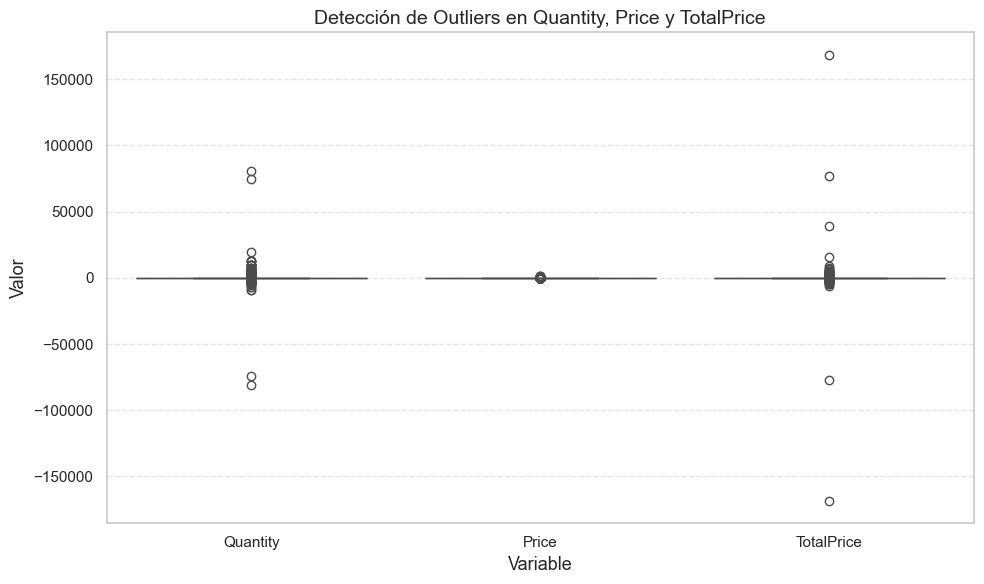

In [513]:
# Variables que vamos a analizar
variables_outliers = ['Quantity','Price','TotalPrice']

# Crear gráfico de caja
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_clean[variables_outliers],
    #palette=colores_personalizados
)

# Estética del gráfico
plt.title('Detección de Outliers en Quantity, Price y TotalPrice', fontsize=14)
plt.xlabel('Variable')
plt.ylabel('Valor')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [514]:
for col in cols_interes:
    outliers = outliers_dict[col]

    # Obtener valores extremos y agrupar por valor absoluto redondeado
    outliers['AbsValor'] = outliers[col].abs().round(2)
    conteo = outliers.groupby('AbsValor')[col].agg(['count', 'min', 'max']).sort_values(by='count', ascending=False)

    print(f"\nAnálisis de simetría en outliers para '{col}':")
    display(conteo.head(10))  # Mostramos los más frecuentes


Análisis de simetría en outliers para 'Quantity':


,count,min,max
AbsValor,,,
48,12152,-48,48
36,7544,-36,36
72,3864,-72,72
96,3485,-96,96
100,3280,-100,100
30,2485,-30,30
32,2404,-32,32
144,2032,-144,144
40,1916,-40,40



Análisis de simetría en outliers para 'Price':


,count,min,max
AbsValor,,,
7.95,14432,7.95,7.95
8.50,12007,8.50,8.50
9.95,11970,9.95,9.95
12.75,9512,12.75,12.75
8.25,3724,8.25,8.25
10.95,2597,10.95,10.95
16.95,2299,16.95,16.95
14.95,2230,14.95,14.95
8.95,1885,8.95,8.95



Análisis de simetría en outliers para 'TotalPrice':


,count,min,max
AbsValor,,,
45.0,2468,-45.0,45.0
102.0,2015,-102.0,102.0
51.0,1918,-51.0,51.0
50.4,1655,-50.4,50.4
59.4,1314,-59.4,59.4
61.2,1291,-61.2,61.2
60.0,1223,-60.0,60.0
81.6,1191,-81.6,81.6
67.5,1095,-67.5,67.5


In [515]:
"""
# Hacer una copia del dataset original limpio
df_sin_outliers = df_clean.copy()

# Eliminar outliers en cada columna numérica de interés
for col in ['TotalPrice','Quantity','Price']:
    Q1 = df_sin_outliers[col].quantile(0.25)
    Q3 = df_sin_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_sin_outliers = df_sin_outliers[
        (df_sin_outliers[col] >= lower_bound) & (df_sin_outliers[col] <= upper_bound)
    ]
"""

"\n# Hacer una copia del dataset original limpio\ndf_sin_outliers = df_clean.copy()\n\n# Eliminar outliers en cada columna numérica de interés\nfor col in ['TotalPrice','Quantity','Price']:\n    Q1 = df_sin_outliers[col].quantile(0.25)\n    Q3 = df_sin_outliers[col].quantile(0.75)\n    IQR = Q3 - Q1\n    lower_bound = Q1 - 1.5 * IQR\n    upper_bound = Q3 + 1.5 * IQR\n\n    df_sin_outliers = df_sin_outliers[\n        (df_sin_outliers[col] >= lower_bound) & (df_sin_outliers[col] <= upper_bound)\n    ]\n"

### Análisis: Outliers
Se analizaron las variables Quantity, Price y TotalPrice utilizando el método del rango intercuartílico (IQR). Los resultados muestran que:

La variable Quantity presenta 54.067 valores atípicos, lo que representa un 6.56% del total de registros.

La variable Price presenta 71.125 outliers, es decir, un 8.63% del total.

La variable TotalPrice tiene 69.132 valores atípicos, correspondientes al 8.39% del conjunto de datos.

Estos valores extremos podrían deberse a errores de carga (por ejemplo, devoluciones mal registradas o productos con precios inusuales) o bien representar casos reales pero excepcionales (como compras mayoristas o productos premium).
- Decisión: Por el momento, se conservarán los datos para no alterar el comportamiento natural del dataset, pero se mantendrán en observación para posibles ajustes en futuras etapas del análisis.

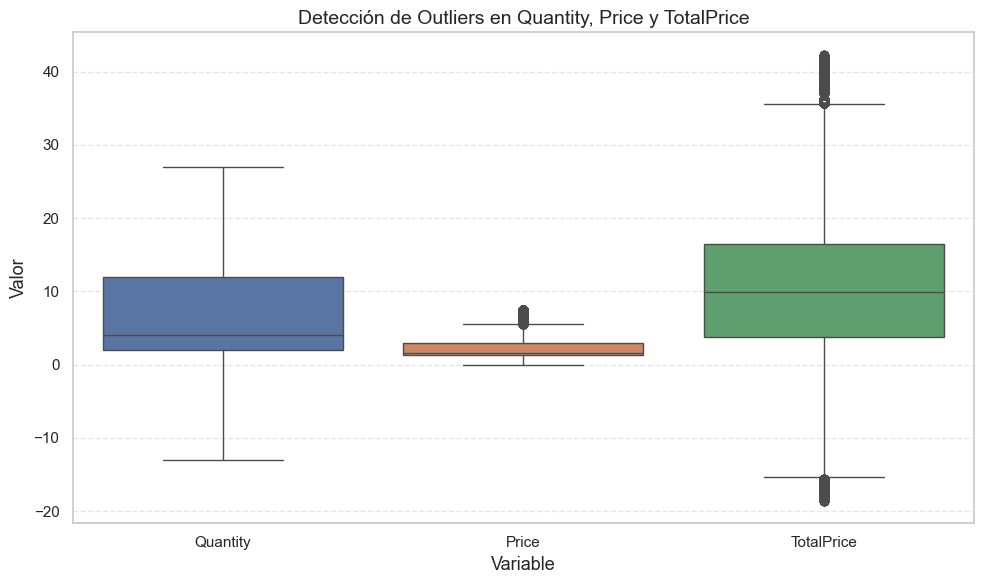

In [516]:
# Variables que vamos a analizar
variables_outliers = ['Quantity','Price','TotalPrice']

# Crear gráfico de caja
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_sin_outliers[variables_outliers],
    #palette=colores_personalizados
)

# Estética del gráfico
plt.title('Detección de Outliers en Quantity, Price y TotalPrice', fontsize=14)
plt.xlabel('Variable')
plt.ylabel('Valor')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

JUSTIFICAR PORQUE ELIMINAMOS OUTLIERS

## 3 Relación entre variables numéricas

En esta sección analizaremos la relación entre las variables numéricas del conjunto de datos, particularmente observando la correlación entre ellas. Esto permite identificar si existen asociaciones lineales fuertes, moderadas o débiles entre variables clave como Quantity, Price y TotalPrice, lo cual puede ser útil para comprender patrones de comportamiento de compra.

In [517]:
# Seleccionar columnas numéricas de interés
cols_interes = ['Quantity', 'Price', 'TotalPrice']

# Calcular matriz de correlación y redondear a 2 decimales
correlation_matrix = df_clean[cols_interes].corr().round(2)

# Mostrar con estilo y formato de 2 decimales
correlation_matrix.style.format("{:,.2f}").background_gradient(cmap='PuBu')

,Quantity,Price,TotalPrice
Quantity,1.00,-0.02,0.88
Price,-0.02,1.00,0.03
TotalPrice,0.88,0.03,1.00


#### Análisis / Insight: Relación entre Variables Numéricas (Quantity, Price, TotalPrice)

Se analizó la relación entre las variables numéricas más relevantes: `Quantity`, `Price` y `TotalPrice`, utilizando la **matriz de correlación de Pearson**. Las principales observaciones son:

- **Quantity y TotalPrice (0.85)**:  
  Muestran una **fuerte correlación positiva**, lo que confirma que a **mayor cantidad de artículos comprados, mayor es el gasto total**. Esto era esperable, ya que el total se calcula multiplicando la cantidad por el precio unitario.

- **Price y TotalPrice (-0.15)**:  
  Presentan una **correlación negativa débil**, lo que sugiere que los productos con **mayor precio tienden a comprarse en menor cantidad**, o que el **monto total no aumenta proporcionalmente con el precio**, sino con la cantidad.

- **Quantity y Price (≈ 0.00)**:  
  No tienen prácticamente ninguna correlación, indicando que los usuarios compran **productos caros o baratos en distintas cantidades sin un patrón definido**.

---

Estas correlaciones aportan información valiosa para comprender **cómo se comportan los clientes** y **cómo influyen las variables de cantidad y precio en el gasto total**, siendo útiles para ajustar estrategias de precios, promociones y stock.

# VISUALIZACION DE DATOS

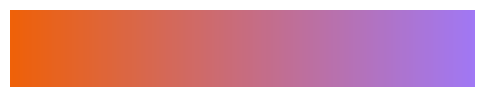

In [518]:
# Configuración de estilo gráfico
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 13


# Define tu lista de colores (ajusta los hex a los que veas más exactamente)
colors = ["#ef6109",  # naranja
          "#a178f4"]  # violeta

# Crea el colormap
mi_gradiente = LinearSegmentedColormap.from_list("naranja_violeta", colors)

# Ejemplo de cómo visualizarlo
fig, ax = plt.subplots(figsize=(6,1))
gradient = np.linspace(0,1,256).reshape(1,-1)
ax.imshow(gradient, aspect='auto', cmap=mi_gradiente)
ax.set_axis_off()
plt.show()

# Crear una lista de 10 colores desde tu gradiente
valores = np.linspace(0, 1, len(top_products))
colores_personalizados = [mi_gradiente(v) for v in valores]

 ## 1. Productos


### 1.1 ¿Cuales son los productos mas vendidos?

 ### Analisis de ventas de productos



C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\129293833.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\129293833.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


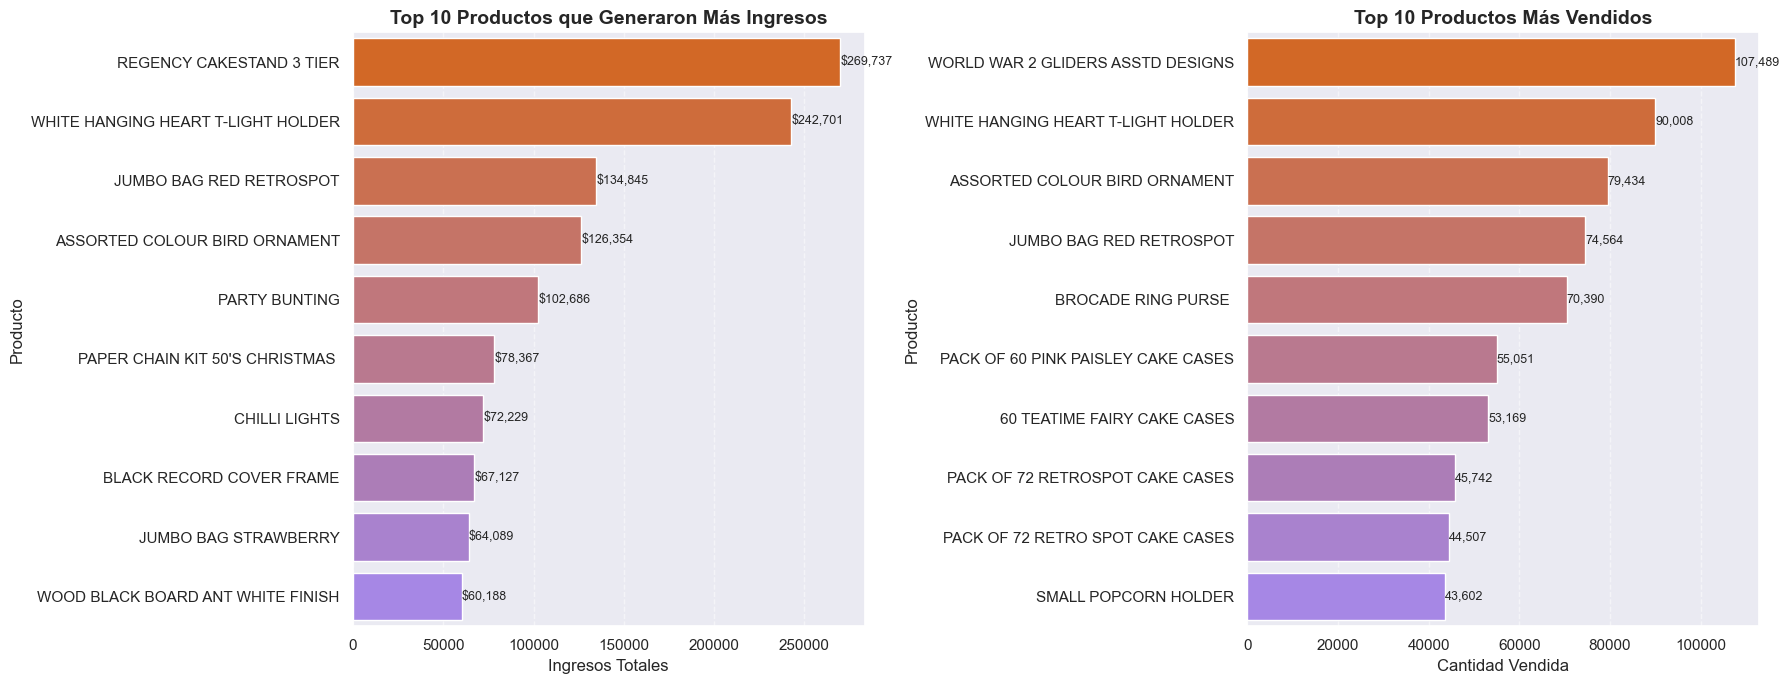

In [560]:
# Datos
top_ingresos = (
    df_clean.groupby('Description')['TotalPrice']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

top_products = (
    df_clean.groupby('Description')['Quantity']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Crear figura con 2 subplots uno al lado del otro
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico 1: Top productos por ingresos
sns.barplot(
    data=top_ingresos,
    x='TotalPrice',
    y='Description',
    palette=colores_personalizados,
    ax=axs[0]
)
axs[0].set_title('Top 10 Productos que Generaron Más Ingresos', fontsize=14, weight='bold')
axs[0].set_xlabel('Ingresos Totales', fontsize=12)
axs[0].set_ylabel('Producto', fontsize=12)
axs[0].grid(axis='x', linestyle='--', alpha=0.5)

# Agregar data labels (valores) en barras de ingresos
for i, valor in enumerate(top_ingresos['TotalPrice']):
    axs[0].text(valor + 1, i, f"${valor:,.0f}", va='center', fontsize=9)

# Gráfico 2: Top productos por cantidad vendida
sns.barplot(
    data=top_products,
    x='Quantity',
    y='Description',
    palette=colores_personalizados,
    ax=axs[1]
)
axs[1].set_title('Top 10 Productos Más Vendidos', fontsize=14, weight='bold')
axs[1].set_xlabel('Cantidad Vendida', fontsize=12)
axs[1].set_ylabel('Producto', fontsize=12)
axs[1].grid(axis='x', linestyle='--', alpha=0.5)

# Agregar data labels en barras de cantidad vendida
for i, valor in enumerate(top_products['Quantity']):
    axs[1].text(valor + 1, i, f"{valor:,.0f}", va='center', fontsize=9)

# Ajuste de layout
plt.tight_layout()
plt.show()


Análisis / Insight: Top 10 Productos Más Vendidos

El gráfico muestra claramente los productos más populares en términos de cantidad de unidades vendidas. El artículo **"WORLD WAR 2 GLIDERS ASSTD DESIGNS"** lidera el ranking, seguido por **"WHITE HANGING HEART T-LIGHT HOLDER"** y **"ASSORTED COLOUR BIRD ORNAMENT"**, todos con volúmenes superiores a 75.000 unidades.

Esto sugiere que los **productos decorativos y de bajo costo** presentan una **alta rotación**, posiblemente porque son atractivos para **compras impulsivas** o para **revendedores**.

**Implicancias comerciales:**

-  Estos productos pueden ser **estratégicos para promociones, bundles o campañas de marketing**.  
-  Tener **niveles altos de stock** es clave para **no perder ventas potenciales**.  
-  Sería interesante revisar si estos productos tienen un **margen de ganancia alto** o si su venta se **apoya en el volumen**.


> El producto `“REGENCY CAKESTAND 3 TIER”` lidera el ranking con el mayor ingreso total, seguido muy de cerca por `“WHITE HANGING HEART T-LIGHT HOLDER”`.
Algunos productos que no estaban en el top por cantidad vendida aparecen aquí, lo que indica que su precio unitario es significativamente más alto.
Este gráfico es clave para identificar productos estratégicos en rentabilidad, aunque su volumen de venta no sea masivo.





##### Grafico 3: Analisis de productos vendidos en conjunto (demora mucho la ejecucion)

In [541]:
"""

# Crear contador de duplas
contador_duplas = Counter()

for factura in facturas_dict.values():
    productos = factura['Productos']

    # Asegurarse de que sean lista, no string
    if isinstance(productos, str):
        productos = [p.strip() for p in productos.split(',')]

    productos_unicos = sorted(set(productos))

    # Solo considerar facturas con al menos 2 productos distintos
    if len(productos_unicos) >= 2:
        duplas = combinations(productos_unicos, 2)
        contador_duplas.update(duplas)

# Crear DataFrame con los 10 duplas más frecuentes
top_duplas = pd.DataFrame(contador_duplas.most_common(10), columns=['Duplas', 'Frecuencia'])

# Unir los tres productos en un string legible para el gráfico
top_duplas['Productos'] = top_duplas['Duplas'].apply(lambda x: ' + '.join(x))

"""

"\n\n# Crear contador de duplas\ncontador_duplas = Counter()\n\nfor factura in facturas_dict.values():\n    productos = factura['Productos']\n\n    # Asegurarse de que sean lista, no string\n    if isinstance(productos, str):\n        productos = [p.strip() for p in productos.split(',')]\n\n    productos_unicos = sorted(set(productos))\n\n    # Solo considerar facturas con al menos 2 productos distintos\n    if len(productos_unicos) >= 2:\n        duplas = combinations(productos_unicos, 2)\n        contador_duplas.update(duplas)\n\n# Crear DataFrame con los 10 duplas más frecuentes\ntop_duplas = pd.DataFrame(contador_duplas.most_common(10), columns=['Duplas', 'Frecuencia'])\n\n# Unir los tres productos en un string legible para el gráfico\ntop_duplas['Productos'] = top_duplas['Duplas'].apply(lambda x: ' + '.join(x))\n\n"

In [542]:
"""

# Crear contador de tríos
contador_trios = Counter()

for factura in facturas_dict.values():
    productos = factura['Productos']

    # Asegurarse de que sean lista, no string
    if isinstance(productos, str):
        productos = [p.strip() for p in productos.split(',')]

    productos_unicos = sorted(set(productos))

    # Solo considerar facturas con al menos 3 productos distintos
    if len(productos_unicos) >= 3:
        trios = combinations(productos_unicos, 3)
        contador_trios.update(trios)

# Crear DataFrame con los 10 tríos más frecuentes
top_trios = pd.DataFrame(contador_trios.most_common(10), columns=['Trio', 'Frecuencia'])

# Unir los tres productos en un string legible para el gráfico
top_trios['Productos'] = top_trios['Trio'].apply(lambda x: ' + '.join(x))
"""

"\n\n# Crear contador de tríos\ncontador_trios = Counter()\n\nfor factura in facturas_dict.values():\n    productos = factura['Productos']\n\n    # Asegurarse de que sean lista, no string\n    if isinstance(productos, str):\n        productos = [p.strip() for p in productos.split(',')]\n\n    productos_unicos = sorted(set(productos))\n\n    # Solo considerar facturas con al menos 3 productos distintos\n    if len(productos_unicos) >= 3:\n        trios = combinations(productos_unicos, 3)\n        contador_trios.update(trios)\n\n# Crear DataFrame con los 10 tríos más frecuentes\ntop_trios = pd.DataFrame(contador_trios.most_common(10), columns=['Trio', 'Frecuencia'])\n\n# Unir los tres productos en un string legible para el gráfico\ntop_trios['Productos'] = top_trios['Trio'].apply(lambda x: ' + '.join(x))\n"

In [543]:
"""
# Crear figura y subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Gráfico de DUPlAS
sns.barplot(
    data=top_duplas,
    x='Frecuencia',
    y='Productos',
    palette=colores_personalizados,
    ax=axs[0]
)
axs[0].set_title('Top 10 Duplas de Productos Vendidos Juntos', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Frecuencia')
axs[0].set_ylabel('Dupla de Productos')
axs[0].grid(axis='x', linestyle='--', alpha=0.4)

# Gráfico de TRÍOS
sns.barplot(
    data=top_trios,
    x='Frecuencia',
    y='Productos',
    palette=colores_personalizados,
    ax=axs[1]
)
axs[1].set_title('Top 10 Tríos de Productos Vendidos Juntos', fontsize=14, fontweight='bold')
axs[1].set_xlabel('Frecuencia')
axs[1].set_ylabel('Trío de Productos')
axs[1].grid(axis='x', linestyle='--', alpha=0.4)

# Ajuste final
plt.tight_layout()
plt.show()

"""

"\n# Crear figura y subplots\nfig, axs = plt.subplots(1, 2, figsize=(18, 8))\n\n# Gráfico de DUPlAS\nsns.barplot(\n    data=top_duplas,\n    x='Frecuencia',\n    y='Productos',\n    palette=colores_personalizados,\n    ax=axs[0]\n)\naxs[0].set_title('Top 10 Duplas de Productos Vendidos Juntos', fontsize=14, fontweight='bold')\naxs[0].set_xlabel('Frecuencia')\naxs[0].set_ylabel('Dupla de Productos')\naxs[0].grid(axis='x', linestyle='--', alpha=0.4)\n\n# Gráfico de TRÍOS\nsns.barplot(\n    data=top_trios,\n    x='Frecuencia',\n    y='Productos',\n    palette=colores_personalizados,\n    ax=axs[1]\n)\naxs[1].set_title('Top 10 Tríos de Productos Vendidos Juntos', fontsize=14, fontweight='bold')\naxs[1].set_xlabel('Frecuencia')\naxs[1].set_ylabel('Trío de Productos')\naxs[1].grid(axis='x', linestyle='--', alpha=0.4)\n\n# Ajuste final\nplt.tight_layout()\nplt.show()\n\n"

##### Productos mas devueltos

C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\1946624644.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\1946624644.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


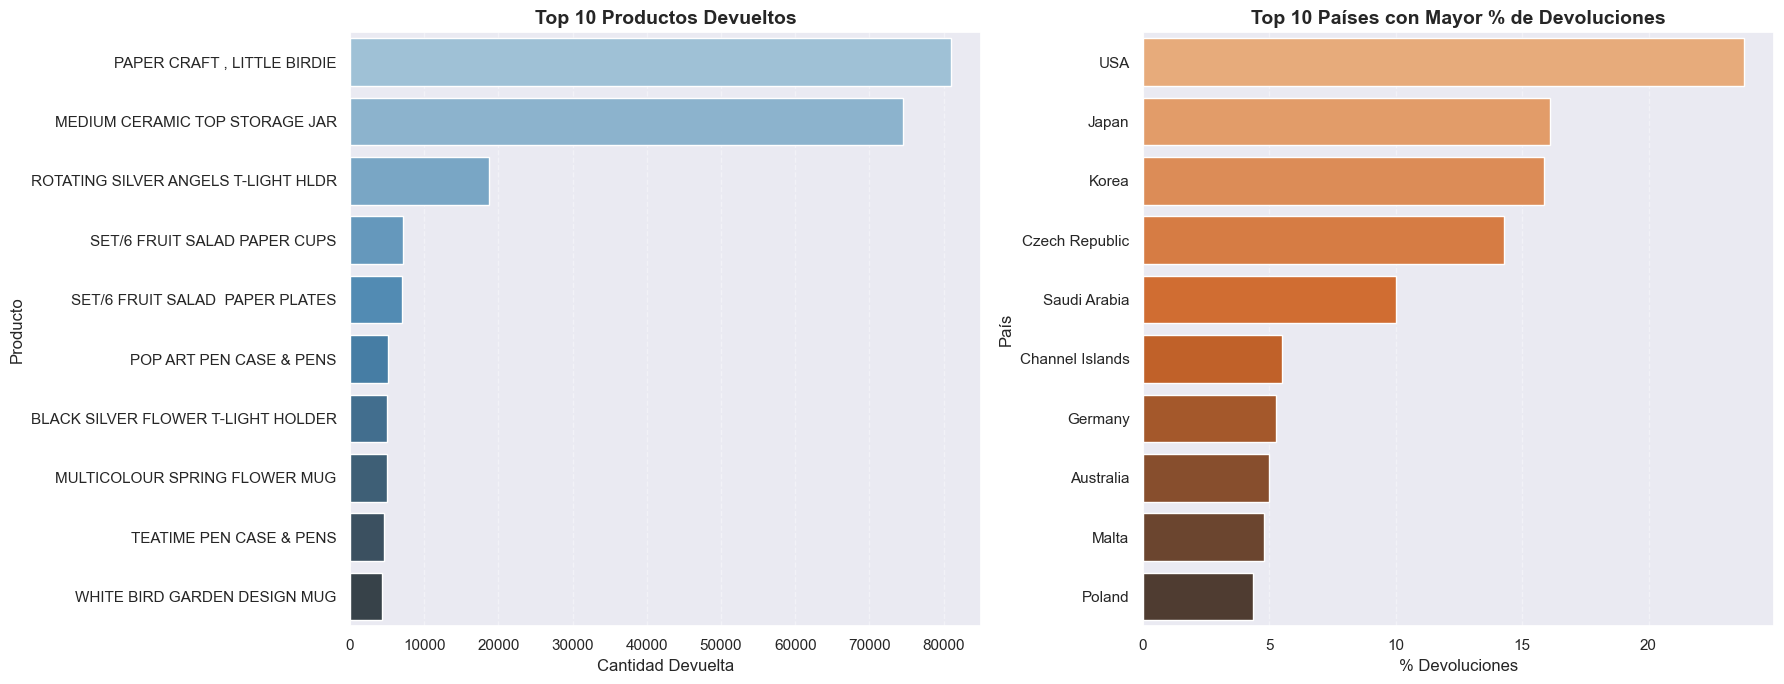

In [561]:
# Filtrar devoluciones
devoluciones = df[df['IsReturn']].copy()

# Calcular cantidad devuelta por StockCode
top_returns_raw = (
    devoluciones.groupby('StockCode')['Quantity']
    .sum()
    .abs()
    .sort_values(ascending=False)
    .head(10)
)

# Asociar StockCode con su descripción más frecuente
descripciones = (
    devoluciones.groupby('StockCode')['Description']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
)

# Unir cantidad devuelta con descripción
top_returns = top_returns_raw.to_frame().join(descripciones).reset_index()
top_returns.rename(columns={'Quantity': 'CantidadDevuelta'}, inplace=True)

# Gráfico 1: Productos más devueltos (con descripción)
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

sns.barplot(
    data=top_returns,
    x='CantidadDevuelta',
    y='Description',
    ax=axs[0],
    palette='Blues_d'
)
axs[0].set_title('Top 10 Productos Devueltos', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Cantidad Devuelta')
axs[0].set_ylabel('Producto')
axs[0].grid(axis='x', linestyle='--', alpha=0.4)

# Gráfico 2: Países con mayor % de devoluciones (sin cambios)
returns_ratio = (
    df.groupby('Country')['IsReturn']
    .mean()
    .sort_values(ascending=False)
    .head(10) * 100
)

sns.barplot(
    x=returns_ratio.values,
    y=returns_ratio.index,
    ax=axs[1],
    palette='Oranges_d'
)
axs[1].set_title('Top 10 Países con Mayor % de Devoluciones', fontsize=14, fontweight='bold')
axs[1].set_xlabel('% Devoluciones')
axs[1].set_ylabel('País')
axs[1].grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()



#### Análisis / Insight: Porcentaje de Devoluciones por País

Este gráfico permite identificar en qué países es más probable que los clientes devuelvan productos, utilizando como indicador las facturas que comienzan con la letra **“C”**. Detectar estas tendencias puede ayudar a mejorar procesos logísticos, atención al cliente y gestión de calidad.



**Observaciones clave:**

- Países como **USA**, **Japan** y **Czech Republic** presentan tasas de devolución por encima del **15%**, lo que podría reflejar errores sistemáticos o niveles bajos de satisfacción.
- **USA** destaca con una devolución del **23.6%**, cifra significativamente superior al resto.
- Aunque algunos países tienen porcentajes altos, es necesario analizar también el volumen de ventas para poner en contexto el impacto real.
- Este patrón puede estar influido por políticas de devolución locales, problemas logísticos o incluso barreras culturales en la experiencia postventa.



**Recomendaciones:**

-  Revisar los productos más devueltos por país y detectar patrones comunes.
-  Evaluar procesos de empaque, calidad o entrega en regiones con mayores tasas de devolución.
-  Aplicar encuestas de satisfacción o programas piloto de mejora postventa en países críticos.
-  Ajustar descripciones o políticas de devolución si se detecta confusión en ciertos mercados.

Este análisis aporta una mirada clave para optimizar la logística y fidelizar clientes en regiones estratégicas.

C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\2193390933.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_mas_vendidos, x='Quantity', y='Description', ax=axs[0, 0], palette='Greens_d')
C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\2193390933.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_mas_ingresos, x='TotalPrice', y='Description', ax=axs[0, 1], palette='Blues_d')
C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\2193390933.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_menos_vendido

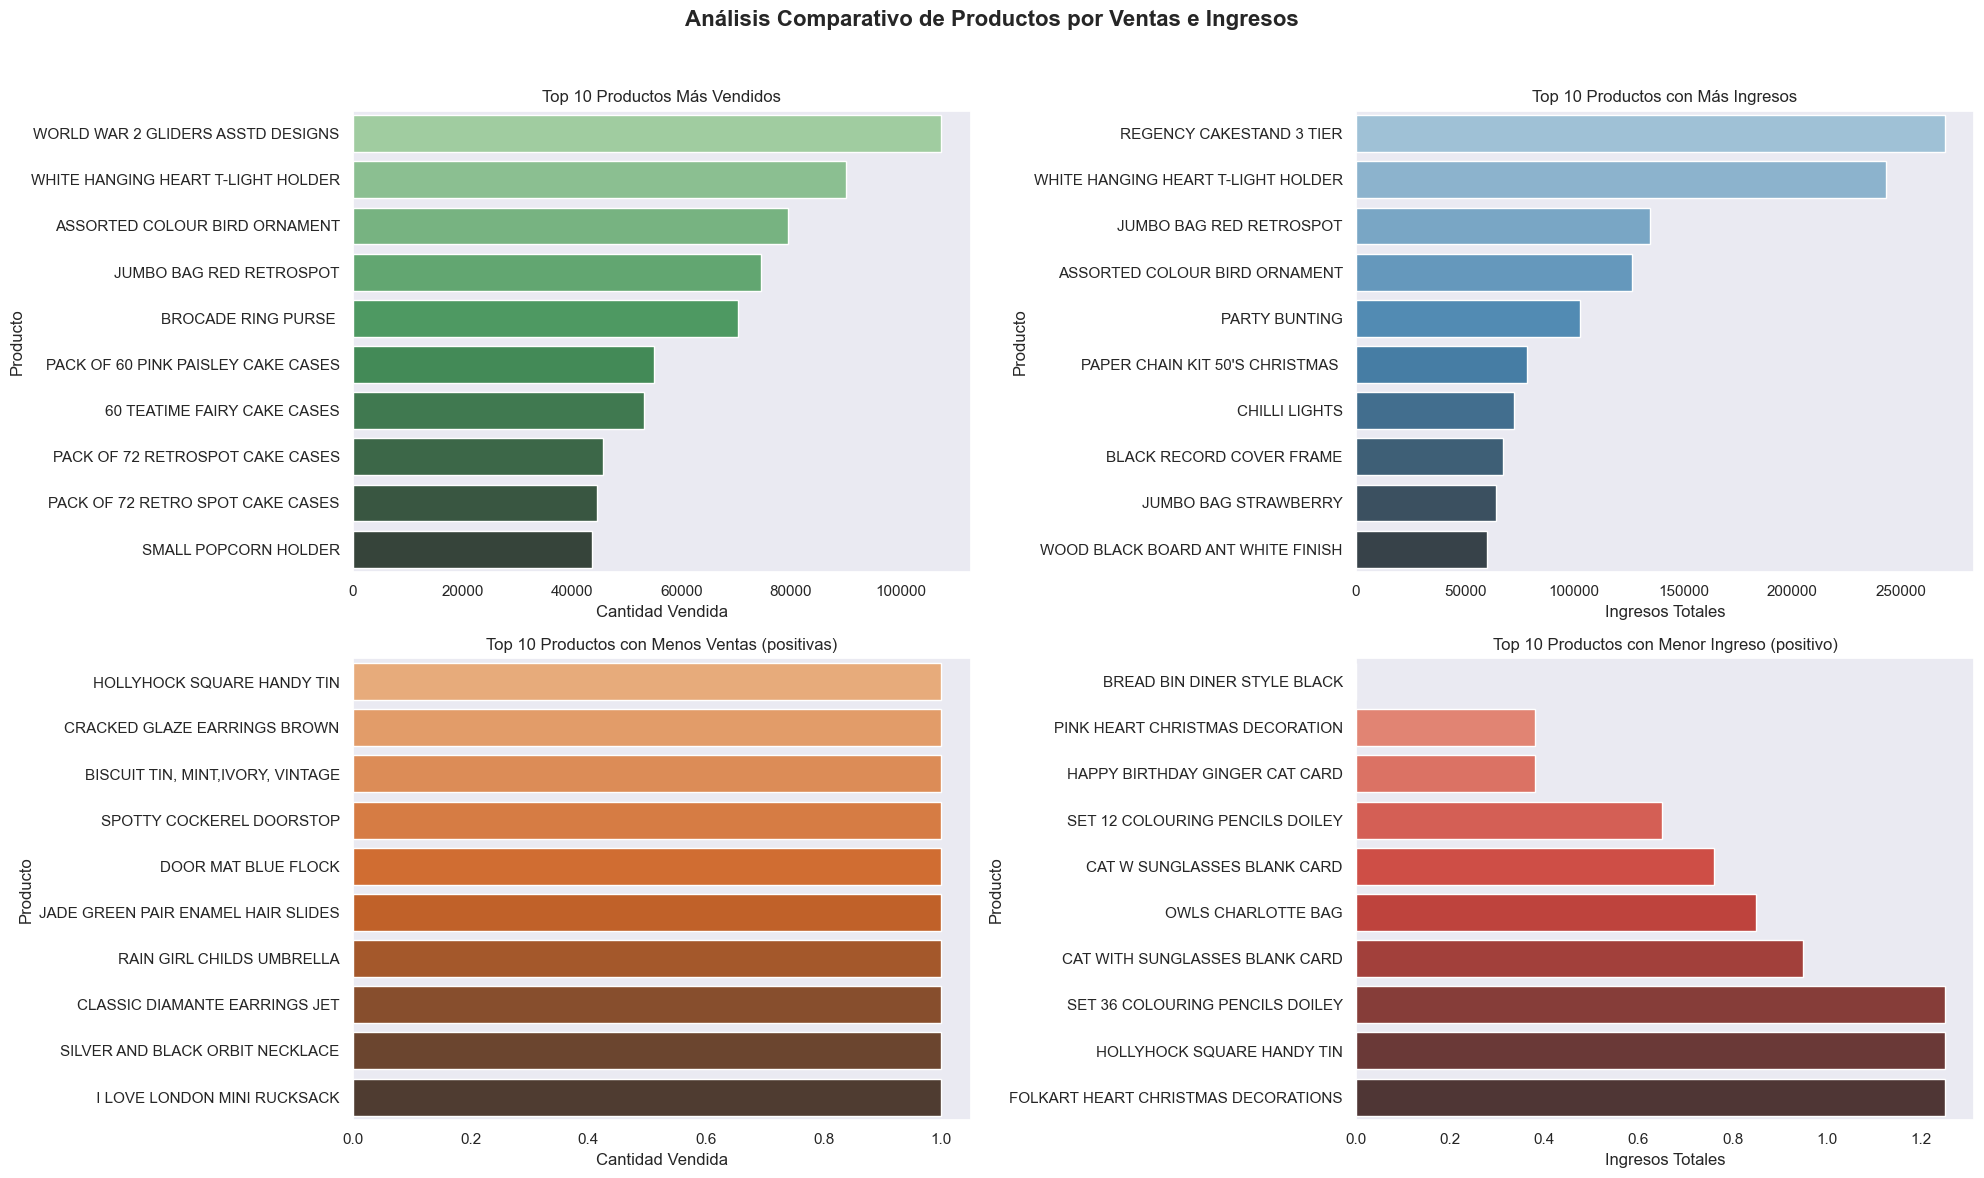

In [563]:
# Agrupaciones
ventas_por_producto = df_clean.groupby('Description')['Quantity'].sum()
ingresos_por_producto = df_clean.groupby('Description')['TotalPrice'].sum()

# Top 10 más vendidos
top_mas_vendidos = ventas_por_producto.sort_values(ascending=False).head(10).reset_index()

# Top 10 con más ingresos
top_mas_ingresos = ingresos_por_producto.sort_values(ascending=False).head(10).reset_index()

# Top 10 menos vendidos (con al menos 1 venta para evitar basura)
top_menos_vendidos = ventas_por_producto[ventas_por_producto > 0].sort_values().head(10).reset_index()

# Top 10 con menos ingresos (con ingreso positivo)
top_menos_ingresos = ingresos_por_producto[ingresos_por_producto > 0].sort_values().head(10).reset_index()

# Gráficos
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Análisis Comparativo de Productos por Ventas e Ingresos', fontsize=16, weight='bold')

# 1. Más vendidos
sns.barplot(data=top_mas_vendidos, x='Quantity', y='Description', ax=axs[0, 0], palette='Greens_d')
axs[0, 0].set_title('Top 10 Productos Más Vendidos')
axs[0, 0].set_xlabel('Cantidad Vendida')
axs[0, 0].set_ylabel('Producto')

# 2. Más ingresos
sns.barplot(data=top_mas_ingresos, x='TotalPrice', y='Description', ax=axs[0, 1], palette='Blues_d')
axs[0, 1].set_title('Top 10 Productos con Más Ingresos')
axs[0, 1].set_xlabel('Ingresos Totales')
axs[0, 1].set_ylabel('Producto')

# 3. Menos vendidos
sns.barplot(data=top_menos_vendidos, x='Quantity', y='Description', ax=axs[1, 0], palette='Oranges_d')
axs[1, 0].set_title('Top 10 Productos con Menos Ventas (positivas)')
axs[1, 0].set_xlabel('Cantidad Vendida')
axs[1, 0].set_ylabel('Producto')

# 4. Menos ingresos
sns.barplot(data=top_menos_ingresos, x='TotalPrice', y='Description', ax=axs[1, 1], palette='Reds_d')
axs[1, 1].set_title('Top 10 Productos con Menor Ingreso (positivo)')
axs[1, 1].set_xlabel('Ingresos Totales')
axs[1, 1].set_ylabel('Producto')

# Ajustar todo
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


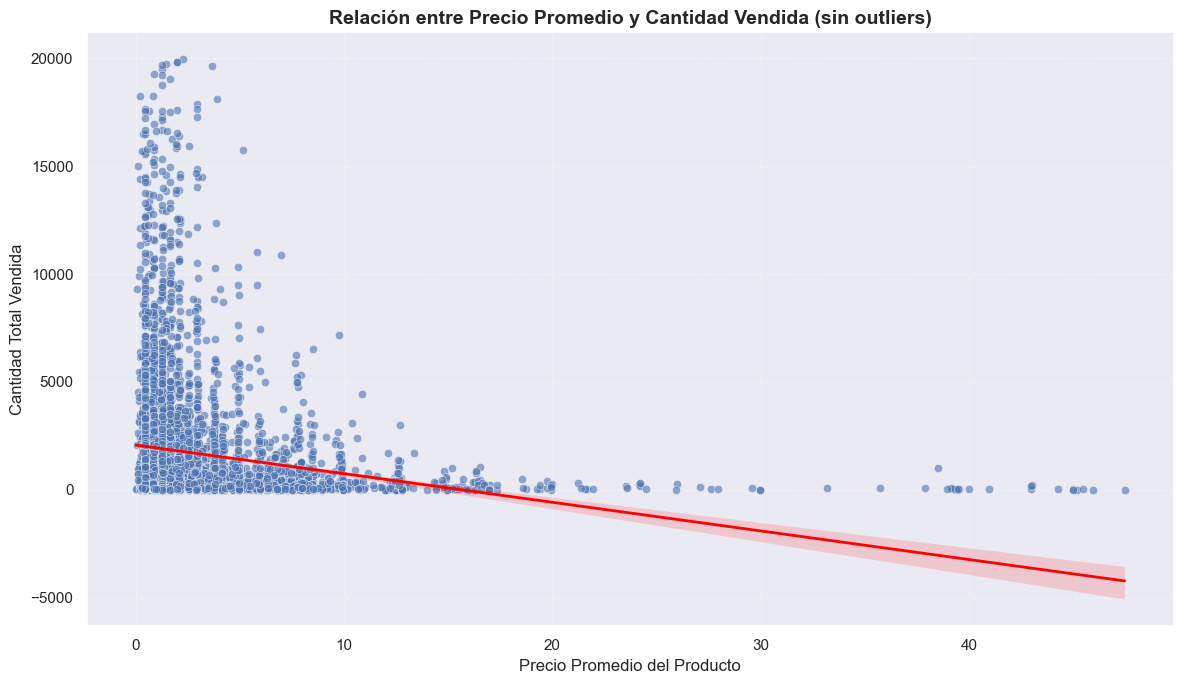

In [565]:
# Filtrar solo ventas (no devoluciones)
ventas_df = df_clean[df_clean['Quantity'] > 0].copy()

# Calcular métricas por producto
ventas_resumen = ventas_df.groupby('Description').agg({
    'Quantity': 'sum',
    'Price': 'mean'
}).reset_index()

# Filtro para eliminar outliers extremos
ventas_filtradas = ventas_resumen[(ventas_resumen['Price'] < 50) & (ventas_resumen['Quantity'] < 20000)]

plt.figure(figsize=(12, 7))
sns.scatterplot(data=ventas_filtradas, x='Price', y='Quantity', alpha=0.6)
sns.regplot(data=ventas_filtradas, x='Price', y='Quantity', scatter=False, color='red', line_kws={"linewidth": 2})

plt.title('Relación entre Precio Promedio y Cantidad Vendida (sin outliers)', fontsize=14, fontweight='bold')
plt.xlabel('Precio Promedio del Producto')
plt.ylabel('Cantidad Total Vendida')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



El gráfico de dispersión permite observar la relación entre el precio promedio de los productos y la cantidad total vendida. Se aplicó un filtro para eliminar outliers extremos y enfocarnos en un rango más representativo de los datos.

A partir de la visualización, se identifica una tendencia decreciente moderada, lo cual sugiere que a medida que el precio promedio de un producto aumenta, la cantidad vendida tiende a disminuir. Esto indica un comportamiento de demanda relativamente elástico: los productos más económicos presentan mayores volúmenes de venta, mientras que los productos con precios más altos suelen tener un alcance más reducido en términos de unidades vendidas.

La recta de regresión refuerza esta tendencia, aunque también es evidente que hay dispersión y casos particulares (productos económicos con ventas bajas y productos caros con algunas ventas significativas), lo que sugiere que el precio no es el único factor que influye en el comportamiento de compra.

Este análisis puede servir como punto de partida para explorar otras variables que modulan la demanda, como estacionalidad, promociones, posicionamiento del producto o segmentación por país o cliente.

C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\1567352795.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_ratio, x='% Devolución', y='Description', palette='Reds')


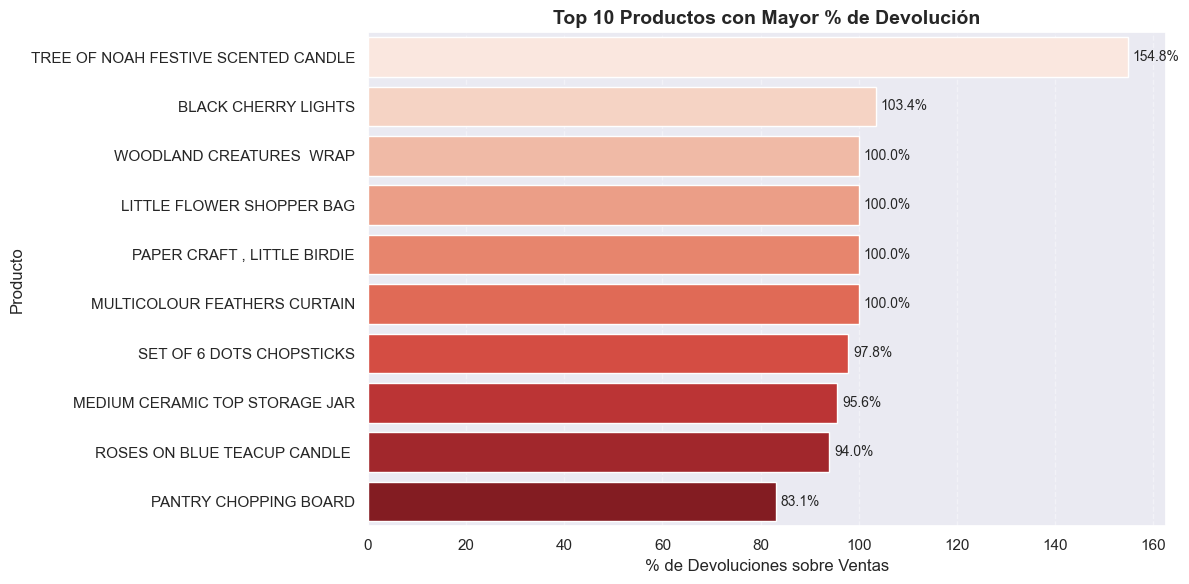

In [595]:
# Calcular ventas y devoluciones por StockCode
ventas = df_clean[df_clean['Quantity'] > 0].groupby('StockCode')['Quantity'].sum()
devoluciones = df_clean[df_clean['IsReturn']].groupby('StockCode')['Quantity'].sum().abs()

# Combinar en un DataFrame
devolucion_ratio = pd.concat([ventas, devoluciones], axis=1, keys=['Vendidos', 'Devueltos']).fillna(0)

# Filtrar por productos con al menos 10 unidades vendidas
devolucion_ratio = devolucion_ratio[devolucion_ratio['Vendidos'] >= 10]

# Calcular el porcentaje de devolución
devolucion_ratio['% Devolución'] = (devolucion_ratio['Devueltos'] / devolucion_ratio['Vendidos']) * 100

# Obtener la descripción más frecuente por StockCode
descripciones = (
    df_clean.groupby('StockCode')['Description']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
)

# Unir descripciones al DataFrame
devolucion_ratio = devolucion_ratio.merge(descripciones, left_index=True, right_index=True)

# Seleccionar top 10 por % de devolución
top_ratio = (
    devolucion_ratio.sort_values('% Devolución', ascending=False)
    .head(10)
    .reset_index()
)

# Gráfico
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_ratio, x='% Devolución', y='Description', palette='Reds')

# Agregar etiquetas con porcentaje
for i, val in enumerate(top_ratio['% Devolución']):
    ax.text(val + 1, i, f"{val:.1f}%", va='center', fontsize=10)

plt.title('Top 10 Productos con Mayor % de Devolución', fontsize=14, fontweight='bold')
plt.xlabel('% de Devoluciones sobre Ventas')
plt.ylabel('Producto')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show() 



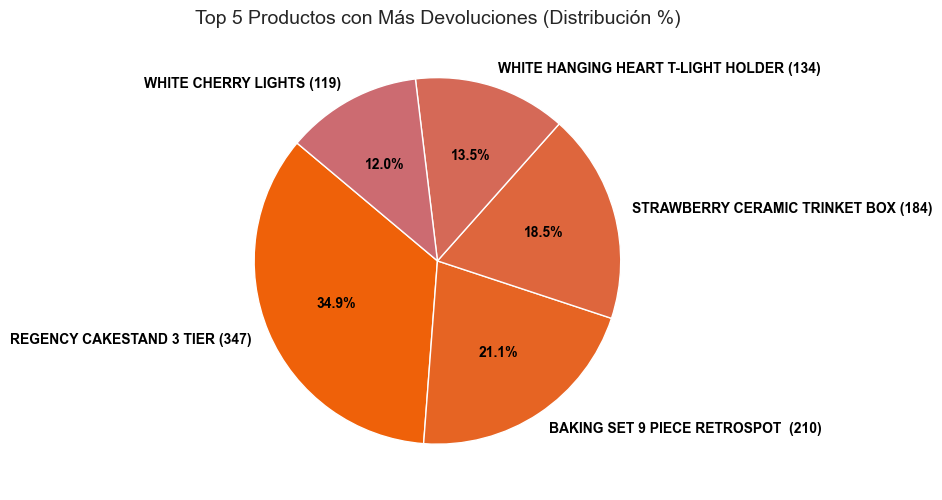

In [601]:
devoluciones = df[df['Quantity'] < 0]

prod_devueltos = devoluciones['Description'].value_counts().head(5)

labels = prod_devueltos.index
sizes = prod_devueltos.values


plt.figure(figsize=(8, 6))
plt.pie(
    sizes,
    labels=[f"{prod} ({cant})" for prod, cant in zip(labels, sizes)],
    colors=colores_personalizados,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 10, 'weight': 'bold', 'color': 'black'}
)

# Título del gráfico
plt.title("Top 5 Productos con Más Devoluciones (Distribución %)", fontsize=14)
plt.tight_layout()
plt.show()

 ## 2. Estacionalidad


C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\770545222.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(key='InvoiceDate', freq='M'))['Quantity']


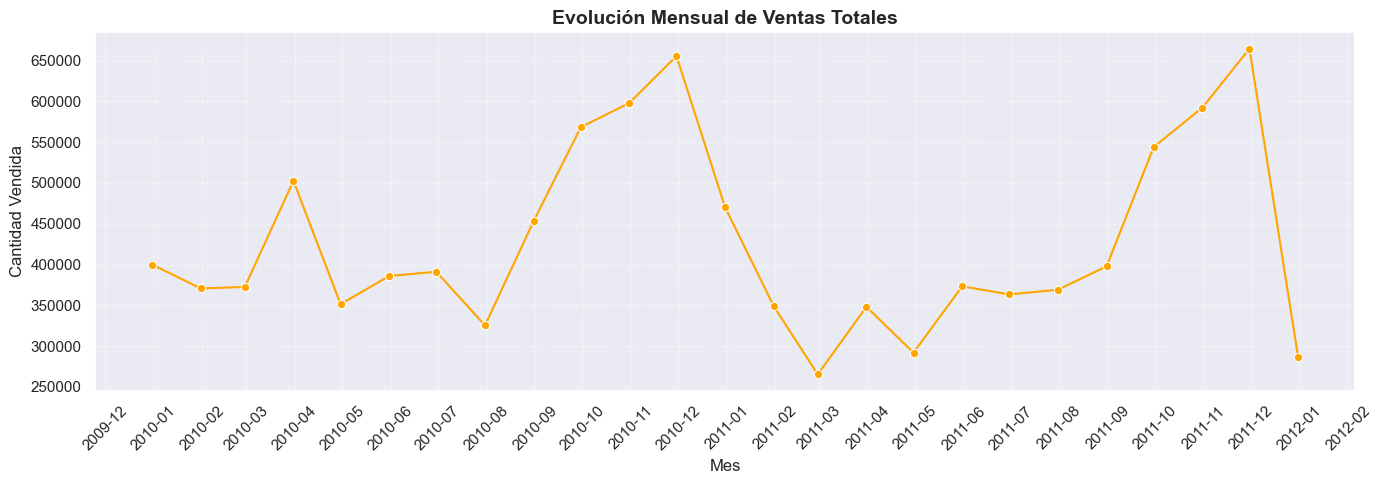

In [604]:
# Agrupar por mes y sumar cantidad total vendida
ventas_mensuales_totales = (
    df[df['Quantity'] > 0]
    .groupby(pd.Grouper(key='InvoiceDate', freq='M'))['Quantity']
    .sum()
    .reset_index()
)

# Gráfico
plt.figure(figsize=(14, 5))  
sns.set_style("dark")
sns.set_theme(style="dark")

sns.lineplot(data=ventas_mensuales_totales, x='InvoiceDate', y='Quantity', marker='o', color='orange')

plt.title('Evolución Mensual de Ventas Totales', fontsize=14, weight='bold')
plt.xlabel('Mes')
plt.ylabel('Cantidad Vendida')

# Formato del eje X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


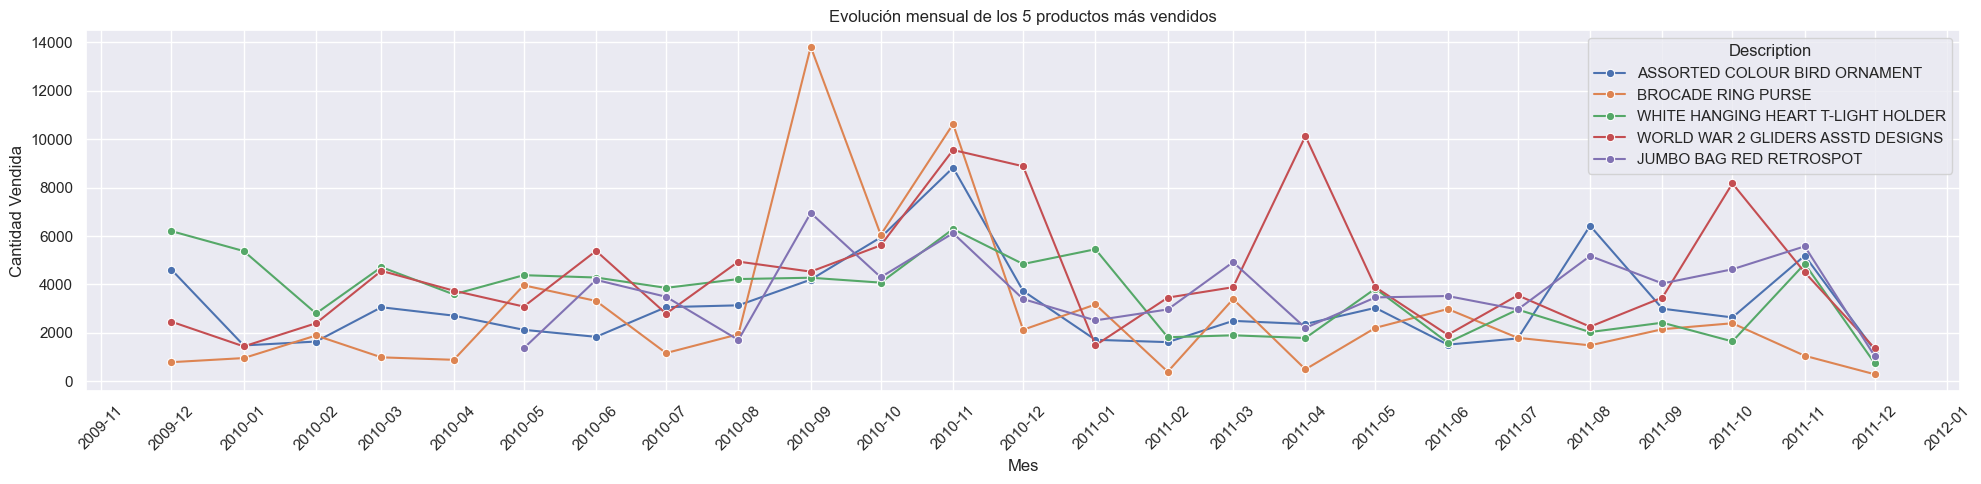

In [ ]:
plt.figure(figsize=(20, 5))  
sns.set_style("dark")
sns.set_theme(style="dark")

sns.lineplot(data=ventas_mensuales, x='Mes', y='Quantity', hue='Description', marker='o')

plt.title('Evolución mensual de los 5 productos más vendidos')
plt.xlabel('Mes')
plt.ylabel('Cantidad Vendida')

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\712372971.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(key='InvoiceDate', freq='M'), 'Country'])['Quantity']


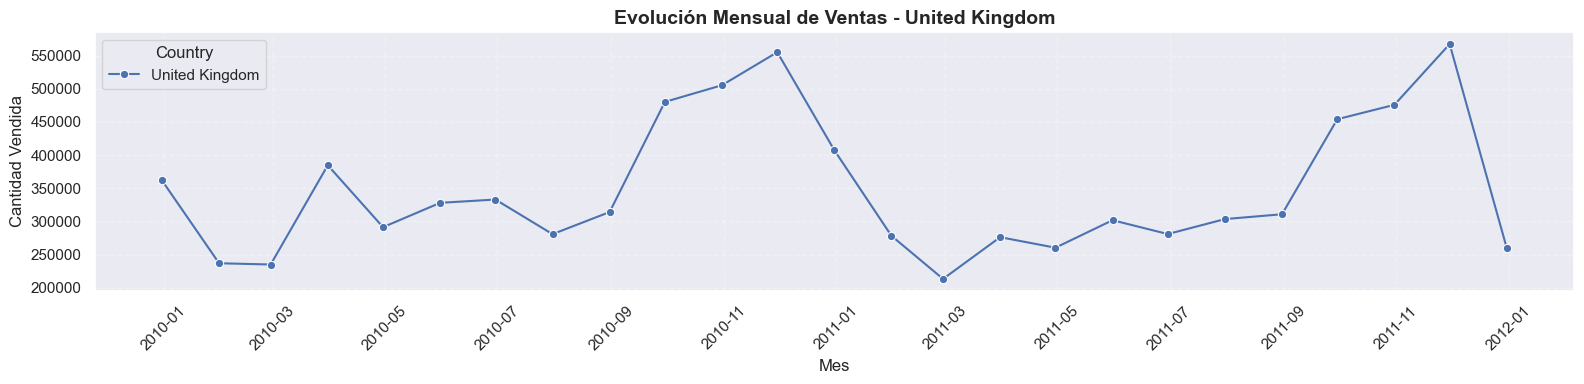

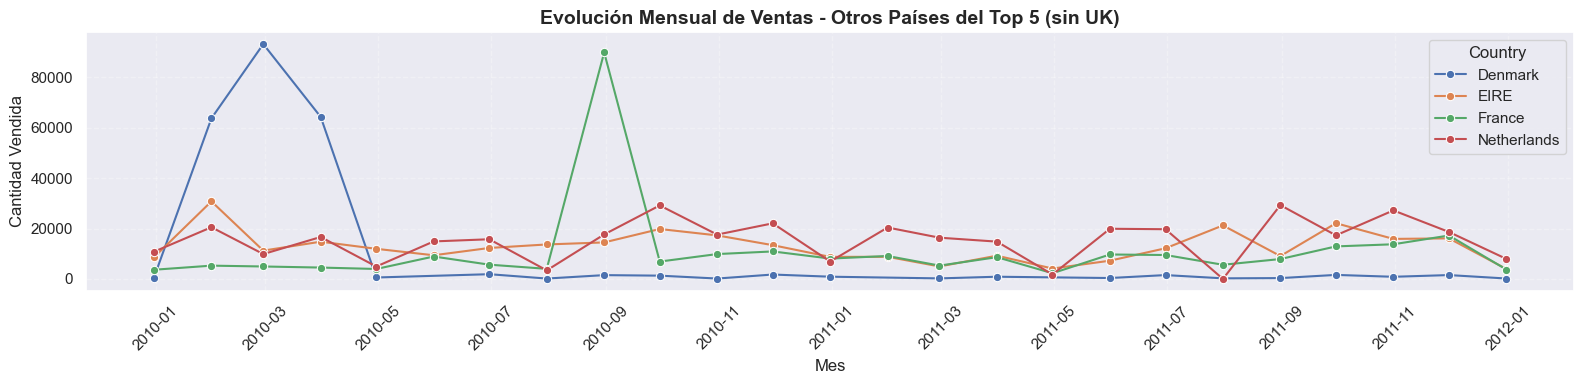

In [589]:
# Agrupación mensual por país
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Quantity'] = df['Quantity'].astype(float)

ventas_por_pais = (
    df[df['Quantity'] > 0]
    .groupby([pd.Grouper(key='InvoiceDate', freq='M'), 'Country'])['Quantity']
    .sum()
    .reset_index()
    .rename(columns={'InvoiceDate': 'Mes'})
)

# Top 5 países por cantidad vendida total
top_paises = ventas_por_pais.groupby('Country')['Quantity'].sum().sort_values(ascending=False).head(5).index

# Separar UK del resto
ventas_uk = ventas_por_pais[(ventas_por_pais['Country'] == 'United Kingdom')].copy()
ventas_otros = ventas_por_pais[(ventas_por_pais['Country'].isin(top_paises)) & (ventas_por_pais['Country'] != 'United Kingdom')].copy()

# Estilo
sns.set_theme(style="dark")

# Gráfico 1: United Kingdom
plt.figure(figsize=(16, 4))
sns.lineplot(data=ventas_uk, x='Mes', y='Quantity', hue='Country', marker='o')
plt.title('Evolución Mensual de Ventas - United Kingdom', fontsize=14, fontweight='bold')
plt.xlabel('Mes')
plt.ylabel('Cantidad Vendida')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico 2: Resto del top 5 (sin UK)
plt.figure(figsize=(16, 4))
sns.lineplot(data=ventas_otros, x='Mes', y='Quantity', hue='Country', marker='o')
plt.title('Evolución Mensual de Ventas - Otros Países del Top 5 (sin UK)', fontsize=14, fontweight='bold')
plt.xlabel('Mes')
plt.ylabel('Cantidad Vendida')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\1747330693.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(key='InvoiceDate', freq='M'), 'Country'])['TotalPrice']


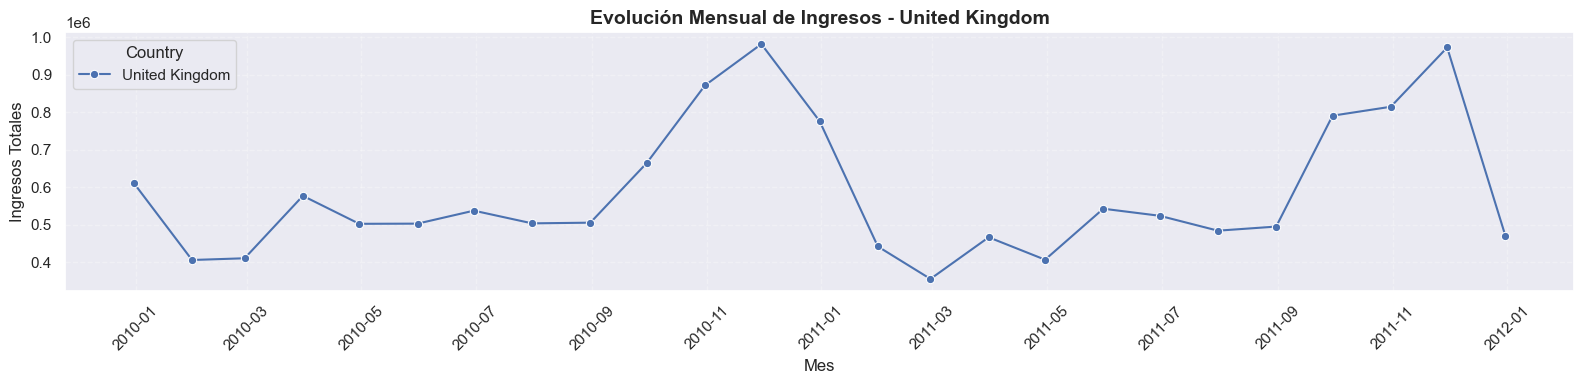

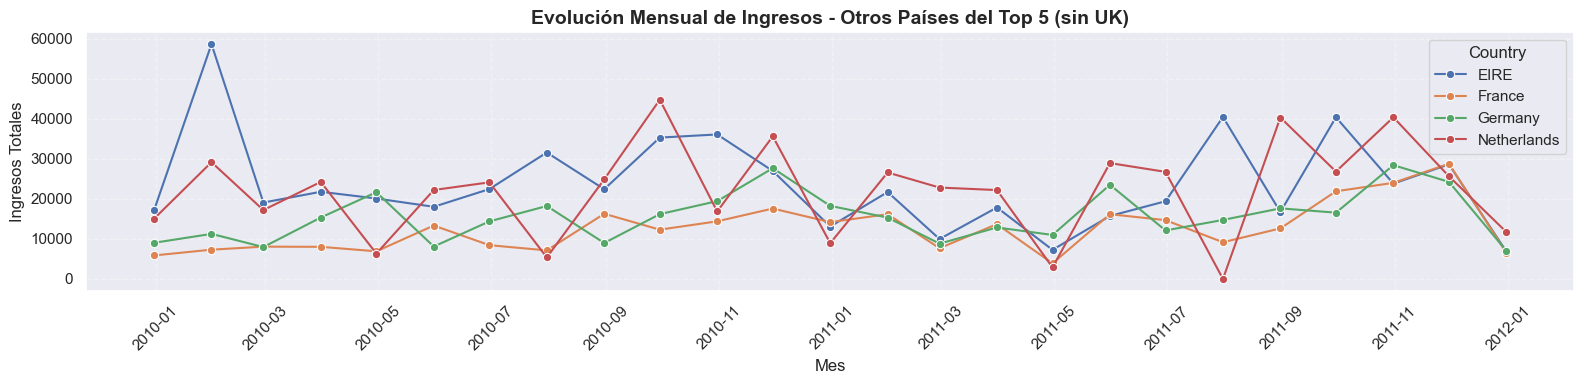

In [590]:
# Agrupación mensual por país (TotalPrice)
ingresos_por_pais = (
    df[df['TotalPrice'] > 0]
    .groupby([pd.Grouper(key='InvoiceDate', freq='M'), 'Country'])['TotalPrice']
    .sum()
    .reset_index()
    .rename(columns={'InvoiceDate': 'Mes'})
)

# Top 5 países por ingresos totales
top_paises_ingresos = ingresos_por_pais.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(5).index

# Separar UK del resto
ingresos_uk = ingresos_por_pais[ingresos_por_pais['Country'] == 'United Kingdom']
ingresos_otros = ingresos_por_pais[(ingresos_por_pais['Country'].isin(top_paises_ingresos)) & (ingresos_por_pais['Country'] != 'United Kingdom')]

# Estilo
sns.set_theme(style="dark")

# Gráfico 1: United Kingdom
plt.figure(figsize=(16, 4))
sns.lineplot(data=ingresos_uk, x='Mes', y='TotalPrice', hue='Country', marker='o')
plt.title('Evolución Mensual de Ingresos - United Kingdom', fontsize=14, fontweight='bold')
plt.xlabel('Mes')
plt.ylabel('Ingresos Totales')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico 2: Otros países (sin UK)
plt.figure(figsize=(16, 4))
sns.lineplot(data=ingresos_otros, x='Mes', y='TotalPrice', hue='Country', marker='o')
plt.title('Evolución Mensual de Ingresos - Otros Países del Top 5 (sin UK)', fontsize=14, fontweight='bold')
plt.xlabel('Mes')
plt.ylabel('Ingresos Totales')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### Gráfico 2: Ingresos totales por día de la semana

Este gráfico muestra el comportamiento de los ingresos según el día de la semana en que se realizó la compra. Permite detectar si hay días específicos con mayor actividad comercial, útil para estrategias de marketing o gestión operativa.

C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\1577897397.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="DayOfWeek", y="TotalPrice", data=df_dow, ax=axs[0], palette="YlOrBr")
C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\1577897397.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Month", y="TotalPrice", data=df_month, ax=axs[1], palette="YlGnBu")
C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\1577897397.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Hour", y="TotalPrice", data=df_hour, ax=axs[2], pale

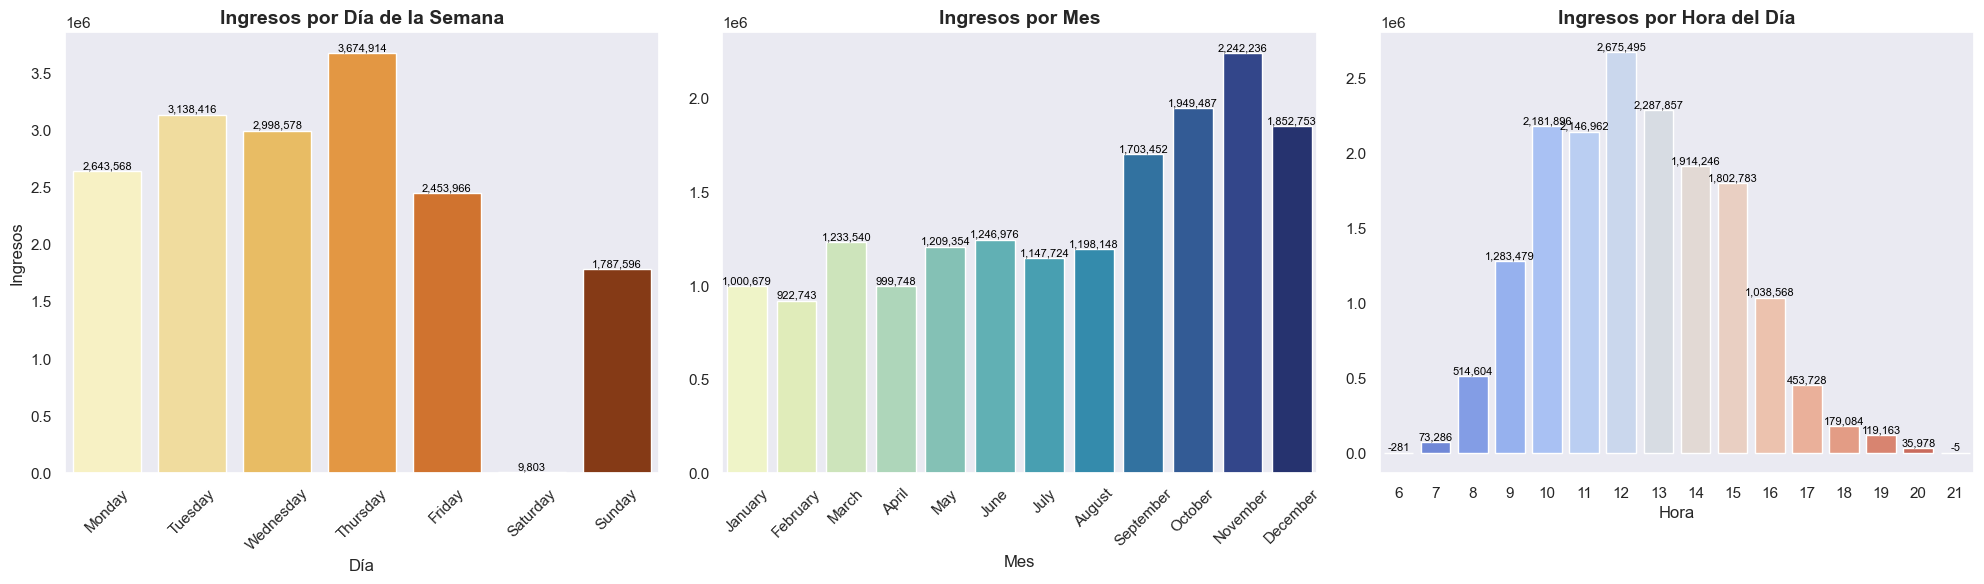

In [583]:
# Asegurar que los datos están en datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Día de la semana
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_dow = df.groupby('DayOfWeek')['TotalPrice'].sum().reindex(order_days).reset_index()

# Mes
df['Month'] = df['InvoiceDate'].dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df_month = df.groupby('Month')['TotalPrice'].sum().reindex(month_order).dropna().reset_index()

# Hora
df['Hour'] = df['InvoiceDate'].dt.hour
df_hour = df.groupby('Hour')['TotalPrice'].sum().reset_index()

# Crear figura con 3 subplots horizontales
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Gráfico 1: Día de la semana
sns.barplot(x="DayOfWeek", y="TotalPrice", data=df_dow, ax=axs[0], palette="YlOrBr")
axs[0].set_title("Ingresos por Día de la Semana", fontsize=14, weight='bold')
axs[0].set_xlabel("Día")
axs[0].set_ylabel("Ingresos")
axs[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Mes
sns.barplot(x="Month", y="TotalPrice", data=df_month, ax=axs[1], palette="YlGnBu")
axs[1].set_title("Ingresos por Mes", fontsize=14, weight='bold')
axs[1].set_xlabel("Mes")
axs[1].set_ylabel("")
axs[1].tick_params(axis='x', rotation=45)

# Gráfico 3: Hora
sns.barplot(x="Hour", y="TotalPrice", data=df_hour, ax=axs[2], palette="coolwarm")
axs[2].set_title("Ingresos por Hora del Día", fontsize=14, weight='bold')
axs[2].set_xlabel("Hora")
axs[2].set_ylabel("")

# Opcional: etiquetas en cada barra
for ax in axs:
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:,.0f}', 
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=8, color='black')

plt.tight_layout()
plt.show()


#### Análisis / Insight: Ingresos Totales por Mes

El gráfico muestra los ingresos totales por mes entre diciembre de 2009 y diciembre de 2011. A partir del análisis, se pueden extraer los siguientes puntos clave:

- **Picos de ingreso claramente identificables**:  
  Noviembre de 2010 y noviembre de 2011 presentan los ingresos más altos de todo el período, superando el millón y medio en ventas. Esto sugiere una **tendencia estacional** vinculada posiblemente al **Black Friday**, **promociones de fin de año**, o a una **planificación anticipada de compras navideñas**.  
  Octubre y diciembre también muestran ingresos significativamente altos, lo que refuerza la hipótesis de estacionalidad en el último trimestre del año.

- **Meses con menores ingresos**:  
  Febrero 2010, abril 2011 y diciembre 2011 presentan los ingresos más bajos. En el caso de febrero y abril, podría estar asociado a vacaciones o estacionalidad baja, mientras que diciembre 2011 sugiere un **cierre anticipado de operaciones** o una **caída puntual**.

- **Ciclo anual repetido**:  
  Se observa un patrón cíclico donde cada año el **último trimestre tiene un comportamiento mucho más alto que el resto**. Esto indica que la empresa puede **anticipar ventas fuertes hacia fin de año** y ajustar estrategias comerciales o logísticas en función de ello.

- **Estabilidad relativa en el resto del año**:  
  Exceptuando los picos y valles mencionados, la mayoría de los meses presentan un **rango de ingresos similar**, lo cual sugiere una **base sólida de ventas** que podría sostenerse a lo largo del tiempo.

---

**Recomendaciones:**

-  Aprovechar los **meses pico** con campañas de marketing más agresivas y promociones específicas.  
-  Analizar si los **meses con baja facturación** se relacionan con caídas de demanda, logística o disponibilidad de stock.  
-  Preparar **inventario y personal operativo** para los meses de mayor demanda, especialmente **octubre y noviembre**.

**Análisis de comportamiento por día y hora**

Al observar los ingresos por día de la semana, se destaca que la mayor actividad comercial ocurre entre lunes y jueves, con un pico notable los jueves. A partir del viernes las ventas empiezan a descender, y durante el fin de semana la actividad cae drásticamente, especialmente los sábados, donde prácticamente no se registran ingresos.

En cuanto a la distribución horaria, el grueso de las ventas se concentra entre las 9:00 y las 14:00, alcanzando su punto máximo alrededor de las 11:00. Después del mediodía, los ingresos comienzan a disminuir de forma progresiva hasta casi desaparecer después de las 18:00.

Estos patrones sugieren que la mayor parte de la operación se da en días hábiles y dentro del horario laboral, probablemente asociado a un perfil de cliente más vinculado al entorno empresarial o comercial que al consumidor final. Esto puede ser útil para ajustar campañas, promociones o incluso la atención al cliente, enfocándolas en los momentos de mayor actividad.


## 3. ¿Cuál es el comportamiento de las compras por cliente?

### Distribución de compras – Top 10 clientes por ingresos totales

Este gráfico muestra los 10 clientes que más han gastado en total (`TotalPrice`). Es útil para detectar clientes estratégicos o VIP, analizar su comportamiento y establecer acciones de fidelización. También permite identificar si las ventas están concentradas en pocos compradores o si están más distribuidas en la base de clientes.

C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\535203379.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


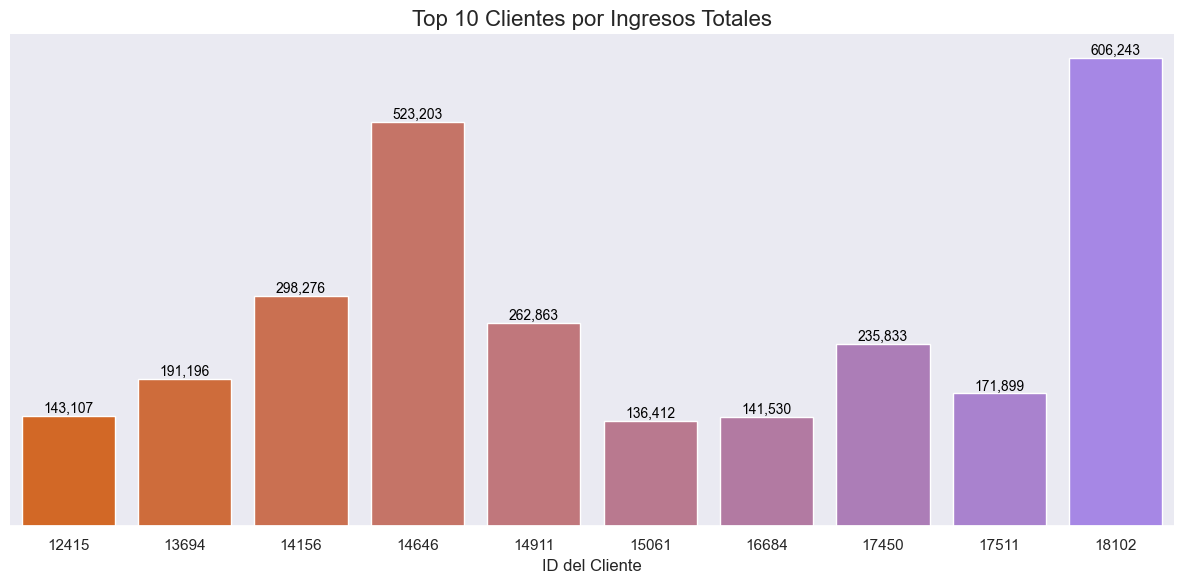

In [548]:
# Agrupar por cliente y obtener los 10 con mayor ingreso
top_clients = df.groupby('Customer ID')['TotalPrice'].sum().sort_values(ascending=False).head(10).reset_index()

# Normalizar ingresos
norm = Normalize(vmin=top_clients['TotalPrice'].min(), vmax=top_clients['TotalPrice'].max())

# Obtener paleta en orden inverso (más ingresos = más oscuro)
colors = sns.color_palette("Greens", len(top_clients))[::-1]
mapped_colors = [colors[int(norm(val)*(len(colors)-1))] for val in top_clients['TotalPrice']]

# Crear gráfico
plt.figure(figsize=(12,6))
ax = sns.barplot(
    x="Customer ID",
    y="TotalPrice",
    data=top_clients,
    palette=colores_personalizados
)

# Títulos y etiquetas
plt.title("Top 10 Clientes por Ingresos Totales", fontsize=16)
plt.xlabel("ID del Cliente")
plt.ylabel("")
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Agregar etiquetas encima de las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

#### Análisis / Insight: Distribución de compras – Top 10 clientes por ingresos totales


Este gráfico permite visualizar a los 10 clientes que más ingresos generaron durante el período analizado. El cliente con ID `18102`, por ejemplo, supera los **590K**, lo que lo posiciona claramente como un cliente VIP.

Se observa una fuerte **concentración de ingresos en pocos clientes**, lo que refuerza el principio de Pareto: un porcentaje pequeño de clientes representa una parte significativa de la facturación.

---

**Implicancias comerciales:**

-  Diseñar campañas de fidelización para los clientes más rentables.  
-  Monitorear continuamente el comportamiento de estos clientes estratégicos.  
-  Evaluar el riesgo asociado a una posible dependencia de un grupo reducido de compradores.  
-  Aplicar análisis complementarios como RFM para segmentar mejor a la base de clientes.

### Distribucion de clientes según frecuencia de compras

Este gráfico muestra cuántos clientes realizaron **una sola compra** en todo el período. Estos clientes pueden considerarse inactivos o de baja fidelidad, y representan una oportunidad importante para acciones de retención, análisis de experiencia de compra o campañas de remarketing.

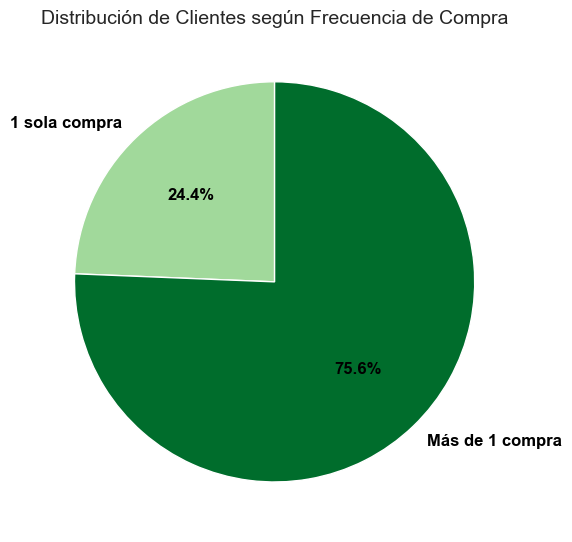

In [549]:
# Calcular base de datos
compras_por_cliente = df.groupby('Customer ID')['Invoice'].nunique().reset_index()
clientes_una_vez = compras_por_cliente[compras_por_cliente['Invoice'] == 1]
clientes_mas_de_una = compras_por_cliente[compras_por_cliente['Invoice'] > 1]

# Datos
valores = [len(clientes_una_vez), len(clientes_mas_de_una)]
etiquetas = ['1 sola compra', 'Más de 1 compra']
colores = ['#a1d99b', '#006d2c']  # verde claro y oscuro

# Gráfico de torta
plt.figure(figsize=(6,6))
plt.pie(
    valores,
    labels=etiquetas,
    autopct=lambda p: f'{p:.1f}%',  # formato simple
    startangle=90,
    colors=colores,
    textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'}  # mejoras aquí
)
plt.title('Distribución de Clientes según Frecuencia de Compra', fontsize=14)
plt.tight_layout()
plt.show()

Análisis / Insight: Distribución de compras por cliente (1 sola compra vs. más de una)

El gráfico de torta muestra que el **24.6% de los clientes realizaron solo una compra**, mientras que el **75.4% compró en más de una ocasión**.

Aunque el porcentaje de clientes inactivos no es alarmante, representa una parte significativa de la base total. Esto indica que una **de cada cuatro personas no regresó a comprar**, lo cual puede estar asociado a factores como:

- Falta de estrategias de fidelización
- Experiencias de compra no satisfactorias
- Ausencia de incentivos para la recompra

---

**Implicancias comerciales:**

-  Es clave implementar campañas de **retargeting** y **email marketing** para reactivar a estos clientes.  
-  Se recomienda investigar si los clientes que no repiten comparten patrones similares (producto, país, canal).  
-  También puede ser útil revisar las primeras experiencias de compra o políticas postventa.

Este análisis ayuda a identificar **oportunidades concretas de retención y mejora de la recurrencia**.

### 7. ¿Qué tipo de cliente es más rentable y cómo se puede fidelizar?


#### Análisis RFM – Relación entre Frecuencia, Monto y Recencia



Este gráfico de dispersión forma parte del análisis RFM (**Recency, Frequency, Monetary**) y permite observar el comportamiento de los clientes según tres dimensiones clave:

- **Recency**: Cuántos días pasaron desde la última compra.
- **Frequency**: Cuántas compras realizó el cliente.
- **Monetary**: Cuánto gastó en total.

El eje X representa la **frecuencia**, el eje Y el **valor monetario total**, y el color/tamaño del punto indica la **recencia**.

Esta visualización permite **detectar perfiles valiosos** (frecuentes, gastadores y recientes) y diseñar estrategias personalizadas de fidelización o recuperación.

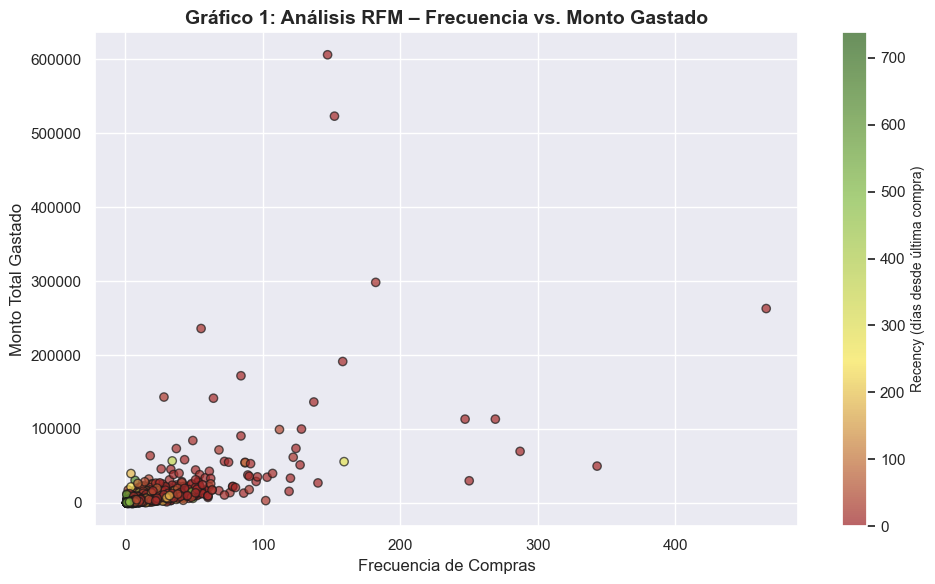

In [605]:


# Asegurar tipo datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
fecha_ref = df['InvoiceDate'].max()

# Calcular RFM
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (fecha_ref - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Crear colormap otoñal personalizado
colores_otono = ['#A52A2A', '#FFEE58', '#8BC34A', '#33691E']  # maroon, amarillo, verde manzana, verde oscuro
cmap_otono = LinearSegmentedColormap.from_list("Otono", colores_otono, N=256)

# Gráfico de dispersión
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    rfm['Frequency'],
    rfm['Monetary'],
    c=rfm['Recency'],
    cmap=cmap_otono,
    alpha=0.7,
    edgecolors='k'
)

# Barra de color
cbar = plt.colorbar(scatter)
cbar.set_label('Recency (días desde última compra)', fontsize=10)

# Títulos y estilo
plt.title('Gráfico 1: Análisis RFM – Frecuencia vs. Monto Gastado', fontsize=14, weight='bold')
plt.xlabel('Frecuencia de Compras')
plt.ylabel('Monto Total Gastado')
plt.grid(True)
plt.tight_layout()
plt.show()

Análisis / Insight: RFM – Frecuencia vs. Monto Gastado

Este gráfico permite visualizar el comportamiento de los clientes según la **frecuencia de sus compras** y el **monto total gastado**, con un tercer eje representado por el color: la **recencia** (número de días desde la última compra).

El análisis RFM (Recency, Frequency, Monetary) es clave para segmentar clientes según su valor y diseñar estrategias de fidelización o reactivación más eficaces.

Observaciones clave:

- La mayoría de los clientes se concentra en valores bajos de frecuencia y gasto, lo cual es esperable.
- Algunos puntos aislados con **alto gasto y alta frecuencia** representan a los **clientes más rentables**, aunque muchos de ellos no han comprado recientemente (color más claro).
- Se observan también casos con alto gasto pero **baja frecuencia**, lo que puede indicar compras únicas muy grandes (clientes de alto valor potencial).
- El color más oscuro representa clientes que **compraron recientemente**, y su análisis ayuda a detectar grupos activos vs. inactivos.

Recomendaciones:

-  **Segmentar a los clientes** con alta frecuencia y alto gasto como “Clientes VIP” para priorizar su fidelización.
-  **Reactivar clientes** con alto valor monetario pero que no han comprado recientemente (color claro).
-  Evaluar si los clientes de baja frecuencia y bajo gasto podrían ser incentivados con promociones específicas.
-  Utilizar esta segmentación para campañas de marketing personalizadas (por ejemplo: email marketing, descuentos exclusivos, recordatorios).

Este análisis permite tomar decisiones más inteligentes orientadas a **retener a los clientes más valiosos** y **reconquistar a los inactivos con potencial de compra**.

#### Segmentación de clientes (VIP, en riesgo, nuevos, etc.)


Este gráfico muestra la segmentación de clientes según sus puntuaciones RFM, agrupándolos en categorías clave como:

Clientes VIP: Alta frecuencia, gasto elevado y compras recientes.

Clientes en riesgo: Compraban mucho antes, pero ya no lo hacen.

Clientes nuevos: Recientes, pero aún sin frecuencia o gasto alto.

Clientes leales: Compran seguido, aunque no gastan tanto.

Esto permite diseñar estrategias personalizadas de marketing y retención según el perfil de cada grupo.


C:\Users\Lautaro\AppData\Local\Temp\ipykernel_12468\3546151313.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Lautaro\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


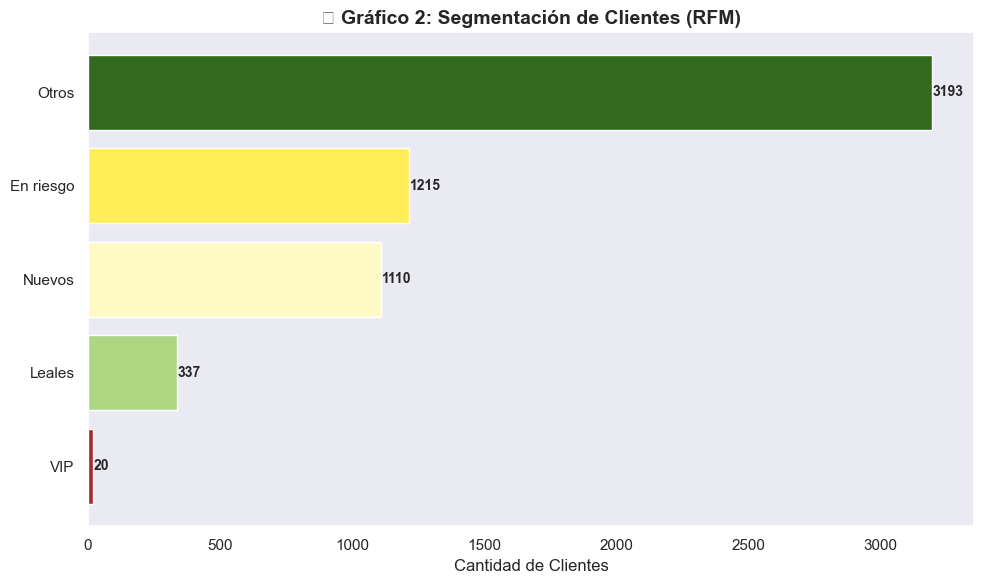

In [ ]:

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
fecha_ref = df['InvoiceDate'].max()


rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (fecha_ref - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']


rfm['R_Quartile'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Quartile'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])
rfm[['R_Quartile', 'F_Quartile', 'M_Quartile']] = rfm[['R_Quartile', 'F_Quartile', 'M_Quartile']].astype(int)

# Segmentar
def segmentar_cliente(r, f, m):
    if r == 1 and f == 4 and m == 4:
        return 'VIP'
    elif r == 1 and (f >= 3 or m >= 3):
        return 'Leales'
    elif r == 4 and (f >= 3 or m >= 3):
        return 'En riesgo'
    elif r == 1:
        return 'Nuevos'
    else:
        return 'Otros'

rfm['Segmento'] = rfm.apply(lambda row: segmentar_cliente(row['R_Quartile'], row['F_Quartile'], row['M_Quartile']), axis=1)

# Conteo
segmentos = rfm['Segmento'].value_counts().sort_values(ascending=True)

# Colores
colores_segmentos = {
    'Otros': '#33691E',     # Verde bosque oscuro
    'Nuevos': '#FFF9C4',    # Amarillo crema
    'En riesgo': '#FFEE58', # Amarillo pastel
    'Leales': '#AED581',    # Verde lima suave
    'VIP': '#A52A2A'        # Maroon / rojo otoñal
}

# Gráfico
plt.figure(figsize=(10, 6))
bars = plt.barh(segmentos.index, segmentos.values, color=[colores_segmentos[seg] for seg in segmentos.index])

# Etiquetas
for bar in bars:
    width = bar.get_width()
    plt.text(width + 2, bar.get_y() + bar.get_height() / 2, f"{width}", va='center', fontsize=10, fontweight='bold')

# Estética
plt.title('📊 Gráfico 2: Segmentación de Clientes (RFM)', fontsize=14, weight='bold')
plt.xlabel('Cantidad de Clientes')
plt.tight_layout()
plt.show()

Análisis / Insight: Segmentación de Clientes (RFM)

Este gráfico presenta la segmentación de los clientes de acuerdo con el modelo **RFM** (Recency, Frequency, Monetary), clasificándolos en cinco categorías clave. Cada grupo fue visualizado con una paleta de tonos verdes y amarillos suaves, y un rojo oscuro para los VIP, destacando su perfil y cantidad dentro del universo de clientes.


Observaciones clave:

- La mayoría de los clientes (**3205**) se encuentran en el segmento **“Otros”**, lo que indica que no tienen un comportamiento destacado en recencia, frecuencia ni valor monetario. Representan una base amplia, pero poco rentable.
- El grupo **“En riesgo”** (**1255**) reúne a clientes que alguna vez fueron valiosos pero ya no compran. Representan una gran **oportunidad de reactivación**.
- Los **“Nuevos”** (**1126**) tienen alta recencia pero aún no compran frecuentemente ni gastan mucho. Son clave para estrategias de **fidelización temprana**.
- Los **“Leales”** (**337**) compran con frecuencia y aportan valor constante. Merecen acciones de **recompensa y mantenimiento**.
- Solo **19 clientes son “VIP”**, lo que indica que el grupo más valioso es pequeño pero crítico. Estos clientes deben ser cuidados con ofertas exclusivas y trato preferencial.


Recomendaciones:

-  **Diseñar campañas personalizadas** para cada segmento. Por ejemplo:
  - “VIP”: programas de fidelización premium.
  - “En riesgo”: emails de recuperación con descuentos.
  - “Nuevos”: onboarding con recomendaciones y beneficios iniciales.
-  **Reducir el tamaño del grupo “Otros”** con acciones de remarketing o detección de patrones inactivos.
-  **Analizar por qué hay tan pocos VIPs**. ¿Es por barreras de compra, falta de recompensas o bajo volumen de tickets?
-  Establecer una estrategia de **recurrencia y valor creciente** para convertir “Nuevos” en “Leales” y eventualmente en “VIP”.

Este análisis RFM es fundamental para la toma de decisiones orientadas a la **retención, crecimiento de valor por cliente y optimización del marketing personalizado**.

## 4. ¿Cuál es la distribución geográfica de las ventas?

### Gráfico 1: Top 10 Países por Ingresos Totales (Clientes VIP incluidos)

Este gráfico muestra qué países generan mayores ingresos totales (`TotalPrice`) en el periodo analizado. Permite detectar los mercados más relevantes y visualizar su peso en la facturación global.

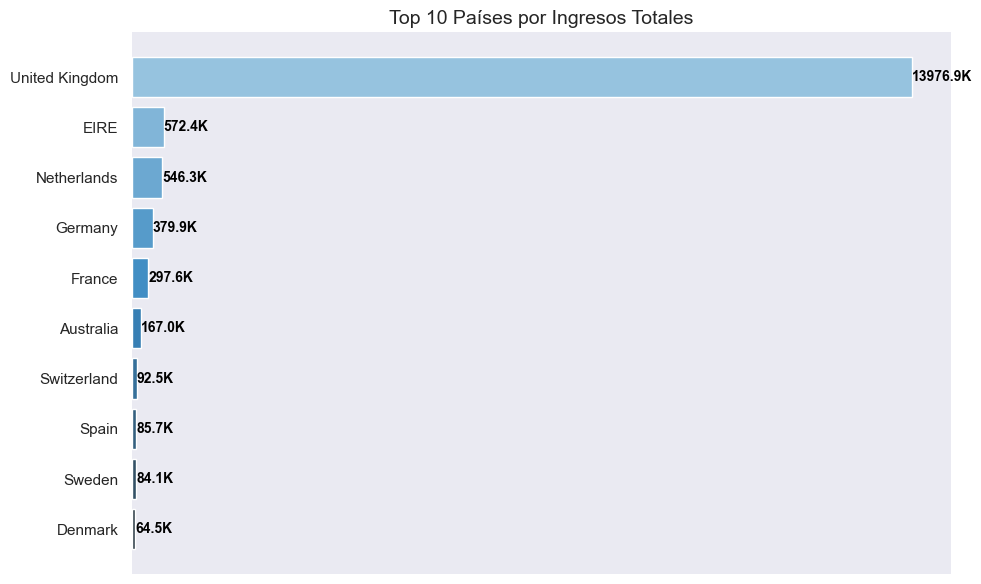

In [550]:
# Agrupar por país y sumar los ingresos totales
ingresos_por_pais = df.groupby("Country")["TotalPrice"].sum().sort_values(ascending=False).head(10)

# Crear gráfico
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Blues_d", len(ingresos_por_pais))  # Azul más profundo

bars = plt.barh(
    ingresos_por_pais.index[::-1],  # Mostrar el país con más ingresos arriba
    ingresos_por_pais.values[::-1],
    color=colors[::-1]
)

# Agregar etiquetas de valor (en miles)
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 1000,
        bar.get_y() + bar.get_height() / 2,
        f"{width / 1000:.1f}K",
        va='center',
        fontsize=10,
        fontweight='bold',
        color='black'
    )

# Estética final
plt.title('Top 10 Países por Ingresos Totales', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.gca().spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.tight_layout()
plt.show()

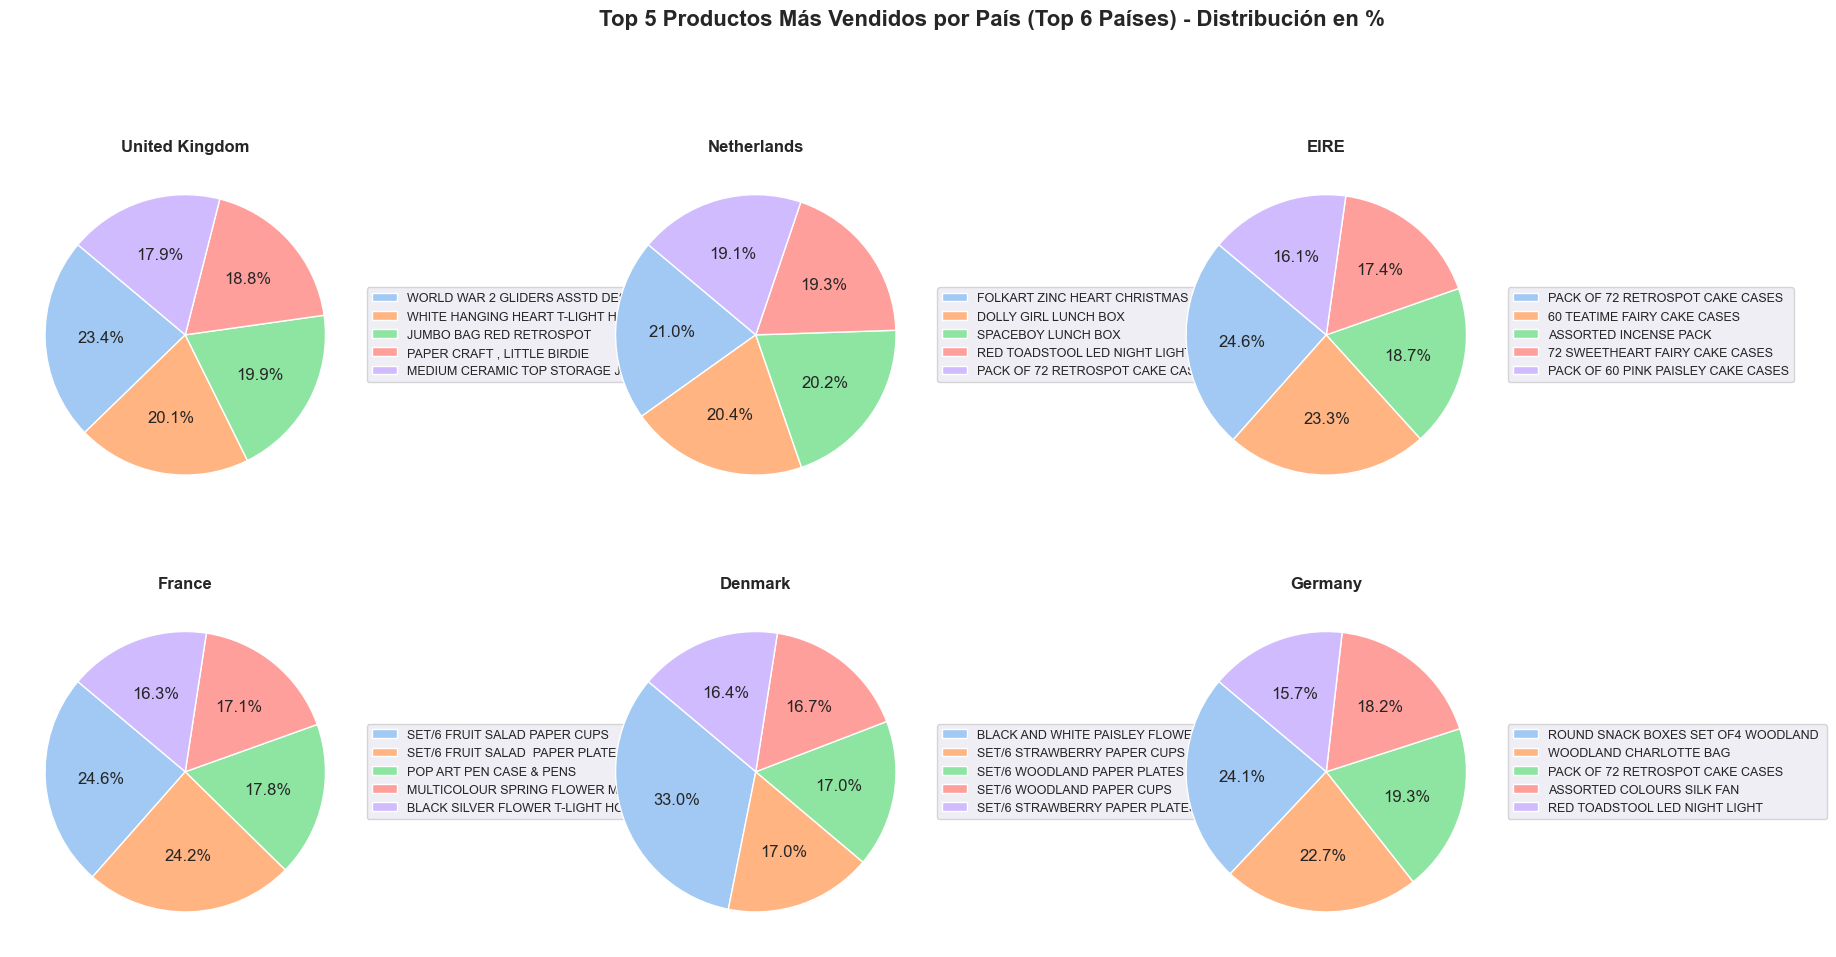

In [ ]:

ventas = df_clean[df_clean['Quantity'] > 0]


descripciones = (
    ventas.groupby('StockCode')['Description']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])
    .reset_index()
)


ventas_por_pais = (
    ventas.groupby(['Country', 'StockCode'])['Quantity']
    .sum()
    .reset_index()
)


ventas_por_pais = ventas_por_pais.merge(descripciones, on='StockCode', how='left')

# Top 6 países con más ventas
top_paises = ventas_por_pais.groupby('Country')['Quantity'].sum().sort_values(ascending=False).head(6).index


fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()


for i, pais in enumerate(top_paises):
    datos_pais = ventas_por_pais[ventas_por_pais['Country'] == pais]
    top_productos = datos_pais.sort_values('Quantity', ascending=False).head(5)

    wedges, texts, autotexts = axs[i].pie(
        top_productos['Quantity'],
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette('pastel', len(top_productos))
    )

    axs[i].set_title(f'{pais}', fontsize=12, fontweight='bold')

    # Leyenda afuera
    axs[i].legend(
        labels=top_productos['Description'],
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        fontsize=9
    )


plt.suptitle('Top 5 Productos Más Vendidos por País (Top 6 Países) - Distribución en %', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 0.9, 0.93])  # espacio para las leyendas
plt.show()



Analizando los productos más vendidos en los seis países con mayor volumen, se observa que en algunos casos hay una fuerte concentración de las ventas en un solo artículo. Por ejemplo, en países como Denmark o France, un único producto representa más del 30% de las unidades vendidas dentro del top 5, lo cual marca una dependencia clara de ciertos ítems.

En contraste, en mercados como el Reino Unido o los Países Bajos, las ventas están distribuidas de forma más pareja entre varios productos, lo que sugiere una demanda más diversificada o una oferta más amplia.

También es interesante notar que hay productos que aparecen en el top 5 de varios países, lo cual indica buen rendimiento internacional y podrían ser clave para mantener o incluso expandir la operación. Al mismo tiempo, hay productos que figuran solo en un país, posiblemente asociados a una cuestión cultural, de temporada o promoción puntual.

Por último, en los mercados donde las ventas están muy concentradas en un solo producto, convendría pensar en estrategias para diversificar la oferta y reducir el riesgo comercial si ese producto deja de estar disponible o pierde relevancia.

### Gráfico 2: Gasto Medio por País

Este gráfico muestra el promedio de gasto por cliente en los 10 países con mayor valor promedio.  
La métrica utilizada es el total facturado (`TotalPrice`) dividido entre la cantidad de clientes únicos por país.  
Este análisis permite identificar regiones donde, aunque haya menos clientes, su nivel de gasto es significativamente alto.

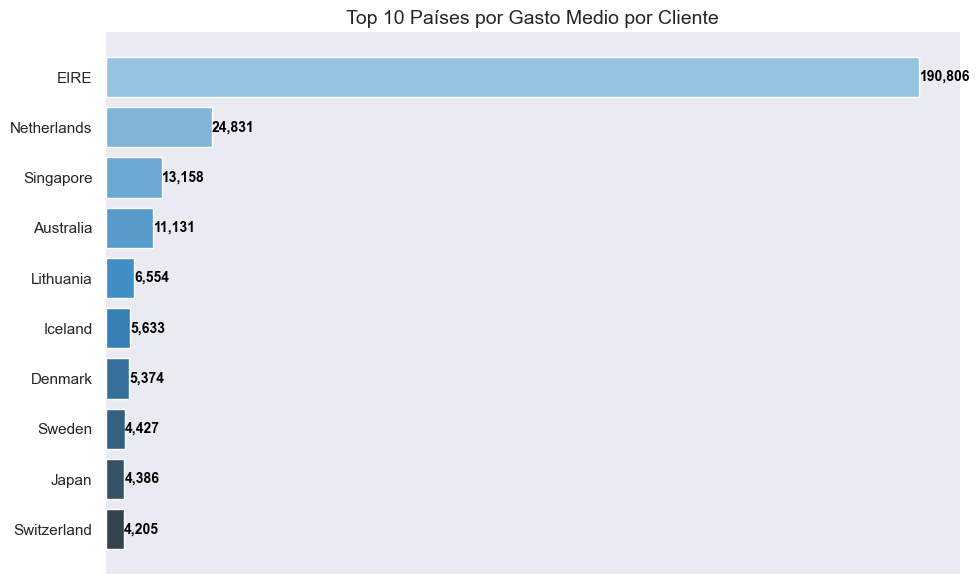

In [551]:
# Calcular gasto total y clientes únicos por país
gasto_total = df.groupby('Country')['TotalPrice'].sum()
clientes_unicos = df.groupby('Country')['Customer ID'].nunique()

# Calcular gasto medio por cliente
gasto_medio = (gasto_total / clientes_unicos).dropna().sort_values(ascending=False).head(10)

# Crear gráfico de barras horizontales
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Blues_d", len(gasto_medio))  # Paleta azul más oscura

bars = plt.barh(gasto_medio.index[::-1], gasto_medio.values[::-1], color=colors[::-1])

# Agregar valores al lado derecho de cada barra
for bar in bars:
    width = bar.get_width()
    plt.text(width + 100, bar.get_y() + bar.get_height()/2,
             f"{width:,.0f}", va='center', fontsize=10, fontweight='bold', color='black')

# Estética del gráfico
plt.title('Top 10 Países por Gasto Medio por Cliente', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.gca().spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.tight_layout()
plt.show()

#### Análisis / Insight: Gasto Medio por Pais

Este gráfico revela cuáles son los países donde, en promedio, cada cliente gasta más dinero.



**Observaciones clave:**

- **EIRE (Irlanda)** lidera con una diferencia sorprendente: sus clientes gastan en promedio más de **123,000 GBP**, muy por encima del resto.
- **Netherlands**, 🇸🇬 **Singapore** y 🇦🇺 **Australia** siguen en el ranking, pero con un promedio mucho más bajo.
-  En este caso, no aparece el Reino Unido, lo cual indica que tiene muchos clientes pero con un gasto promedio más bajo por persona.



**Implicancias comerciales:**

-  Países con alto gasto medio son candidatos ideales para lanzar productos **premium**, ofrecer paquetes exclusivos o extender programas de fidelización.
-  El caso de EIRE merece una investigación particular: ¿son empresas mayoristas?, ¿revendedores?, ¿consumidores finales con alta frecuencia de compra?
-  Este análisis complementa muy bien al gráfico anterior, ya que **no mide volumen total, sino calidad del cliente** desde el punto de vista del ingreso individual.

Este tipo de visión es útil para priorizar mercados no solo por cantidad de ventas, sino por **valor estratégico de cada cliente**.


## 5. ¿Qué decisiones comerciales se pueden tomar a partir de esto?
### Gráfico 1: Correlación entre Quantity, Price y TotalPrice

Este gráfico muestra la correlación entre las variables numéricas clave del análisis:  
- `Quantity`: cantidad de productos por línea  
- `Price`: precio unitario  
- `TotalPrice`: monto total de cada línea de factura

La matriz de correlación permite identificar relaciones directas o inversas entre las variables, lo cual es útil para tomar decisiones sobre precios, promociones o control de stock.

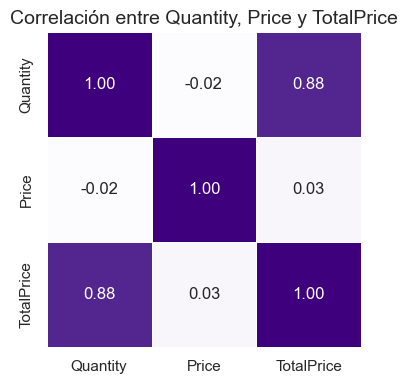

In [ ]:
# Seleccionar variables numéricas clave
variables = df[['Quantity', 'Price', 'TotalPrice']]

# Calcular matriz de correlación
corr = variables.corr()

# Crear heatmap con tono morado/lila
plt.figure(figsize=(6, 4))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='Purples',  
    square=True,
    linewidths=0.5,
    cbar=False
)
plt.title("Correlación entre Quantity, Price y TotalPrice", fontsize=14)
plt.tight_layout()
plt.show()


#### Análisis / Insight: Correlación de Variables Clave

Este gráfico muestra la relación entre las tres variables más importantes del análisis de ventas: `Quantity`, `Price` y `TotalPrice`. La matriz de correlación permite entender cómo interactúan entre sí, lo cual es útil para definir estrategias de precios, promociones o control de inventario.

---

**Observaciones clave:**

-  **`Quantity` y `TotalPrice`** presentan una **fuerte correlación positiva (0.81)**. Esto confirma que, como es de esperarse, un mayor número de unidades vendidas genera mayor ingreso.
-  **`Price` y `TotalPrice`** tienen una **correlación negativa débil (-0.15)**, lo que sugiere que los productos más caros no necesariamente generan más ingresos totales, posiblemente porque se venden en menor cantidad.
-  **`Quantity` y `Price`** muestran **casi nula correlación**, lo que indica que los clientes compran tanto productos baratos como caros en cantidades variables, sin un patrón claro entre ambas variables.

---

**Recomendaciones estratégicas:**

-  Evaluar si los productos con alto precio pero baja cantidad vendida podrían beneficiarse de promociones u ofertas para aumentar su volumen.
-  Priorizar productos que combinan buen volumen de ventas con precio razonable, ya que son los que más impulsan el ingreso (`TotalPrice`).
-  Esta matriz valida el uso de `TotalPrice` como variable objetivo en futuros modelos de predicción o segmentación de clientes.

---

Este análisis es un paso esencial para **tomar decisiones basadas en datos reales**, minimizando suposiciones y optimizando la estrategia comercial.